In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결
sns.set(font="Malgun Gothic",rc={"axes.unicode_minus":False}, style='whitegrid')

In [2]:
data_root = "./data/montly"

# 데이터 과학 입문 Project

---
## 1. Data EDA & Pre-processing

### (1) 데이터 수집 및 분석 데이터 구축

#### - 날씨 데이터

- 수집 기간 : 2000년 1월 ~ 2022년 3월
- 수집 지점 : 서울
- 날씨 변수 : 평균 기온, 합계 강수량, 평균 풍속, 평균상대습도, 합계일조 시간 (월)



####  - 상품군별 판매액지수 데이터

- 수집 기간 : 1995년 1월 ~ 2022년 3월
- 상품 품목 : 승용차, 가전제품, 가구, 의복, 신발 및 가방, 음식료품, 의약품, 화장품, 서적 및 문구
- 사용 지수 : 월 평균 불변지수 (경상지수 / 디플레이터)

날씨 데이터 수집

In [3]:
# 파일 불러오기
weather_df = pd.read_csv(f'{data_root}/weather_df.csv', encoding='cp949')

# 일시 format 통일을 위한 변경 (ex :2000.01 -> 2000-01)
weather_df['시점'] = weather_df['시점'].astype('str').str.replace(pat='.', repl='-', regex=False)

# 분석에 필요없는 변수 제거
weather_df = weather_df.drop(['관측지점별', '최고기온','최저기온'],axis=1)
display(weather_df.head(10))

,시점,평균기온,합계강수량,평균풍속,평균상대습도,합계일조시간
0,2000-01,-2.1,42.8,2.6,64,108.3
1,2000-02,-1.7,2.1,2.7,56,139.3
2,2000-03,6.3,3.1,3.0,55,152.8
3,2000-04,11.9,30.7,2.9,56,156.6
4,2000-05,17.5,75.2,2.3,66,138.3
5,2000-06,23.7,68.1,1.9,65,133.0
6,2000-07,26.8,114.7,2.1,73,108.2
7,2000-08,26.2,599.4,1.7,79,112.8
8,2000-09,20.7,178.5,1.7,71,116.4
9,2000-1,14.9,18.1,1.5,64,131.3


판매액지수 데이터 수집

In [4]:
# 상품 군별 판매액지수 데이터 불러오기
product_df = pd.read_csv(f'{data_root}/재별및상품군별_판매액지수.csv', encoding='cp949', index_col=0).T
product_df.columns = [product_df.columns, product_df.loc['항목']]  # multi column으로 변경 (상품군 , 지수종류)
product_df = product_df.drop(index=['항목','단위'])

# 사용할 컬럼 선택
product_sales_type = '불변지수'
product_columns = ['승용차', '가전제품','가구','의복', '가방', '음식료품','의약품','화장품', '서적, 문구']
product_column_sales_type = [(p, product_sales_type) for p in product_columns] # 멀티 컬럼 형태로 변환
selected_product_df = product_df[product_column_sales_type].apply(pd.to_numeric)

# index 변경 및 일시 데이터 컬럼 생성, format 변환
selected_product_df['시점'] = selected_product_df.index.map(lambda x:f"{x[0:4]}-{x[5:7]:0<2}")
selected_product_df = selected_product_df.reset_index(drop=True)
selected_product_df.columns = [c[0] for c in selected_product_df.columns]

display(selected_product_df.tail(3))

,승용차,가전제품,가구,의복,가방,음식료품,의약품,화장품,"서적, 문구",시점
324,99.3,189.8,116.5,90.8,117.2,132.5,136.4,135.4,114.3,2022-01
325,114.4,187.3,114.2,77.8,110.7,94.5,157.9,132.6,99.9,2022-02
326,140.0,190.6,119.8,99.8,121.7,108.4,170.3,152.7,123.0,2022-03


날씨 데이터와 판매지수 데이터 합치기

In [5]:
df_dict = {}

for p in product_columns:
    tmp_df = selected_product_df[[p]+['시점']]
    merged_df = pd.merge(weather_df, tmp_df).dropna()
    merged_df = merged_df.reset_index(drop=True)
    df_dict[p] = merged_df
    print(f'상품군 {p}의 데이터 크기 : {df_dict[p].shape}')

상품군 승용차의 데이터 크기 : (245, 7)
상품군 가전제품의 데이터 크기 : (190, 7)
상품군 가구의 데이터 크기 : (190, 7)
상품군 의복의 데이터 크기 : (190, 7)
상품군 가방의 데이터 크기 : (135, 7)
상품군 음식료품의 데이터 크기 : (190, 7)
상품군 의약품의 데이터 크기 : (190, 7)
상품군 화장품의 데이터 크기 : (190, 7)
상품군 서적, 문구의 데이터 크기 : (190, 7)


판매지수에 대한 분류 학습을 위한 데이터 생성

- 해당 연 평균 판매지수에 대한 월 평균 판매지수가 높은지 아닌지에 대한 분류
- (높은 판매지수:1, 낮은 판매지수:0)

In [6]:
# 년 평균 판매지수 대비 높은지 여부 (높음:1, 낮음 :0)
for p in product_columns:
    df_dict[p]['연도'] = df_dict[p]['시점'].str[:4]
    yearly_means = df_dict[p].groupby('연도')[p].mean()
    increase_label_list = []
    for i in df_dict[p]['연도'].unique():
        increase_label_list.extend(df_dict[p][p].loc[df_dict[p]['연도']==i]>int(yearly_means[i]))
    df_dict[p]['년평균대비증감'] = increase_label_list
    df_dict[p]['년평균대비증감'] = df_dict[p]['년평균대비증감'].astype('int')
    
    # 필요없는 '연도' column 버리기
    df_dict[p] = df_dict[p].drop(['연도'],axis=1)
    df_dict[p].columns = ['time', 'temp', 'precip', 'wind', 'humid', 'sun', 'sales','sales_increase'] 
    

---
## 2. 데이터 탐색 및 전처리
### (1) 이상치 제거
#### - Histogram 분석
각각 아래의 변수에 대한 히스토그램 분석을 시행함.
- 날씨
- 판매지수
- 판매지수 증감에 따른 날씨데이터

#### - 이상치 제거
IQR * 1.5와 사분위수 75%, 25%를 이용하여 최소제한선, 최대제한선 이외의 데이터 제거
- 최소제한선 : 사분위수 25% - IQR*1.5
- 최대제한선 : 사분위수 75% + IQR*1.5

날씨 히스토그램 분석

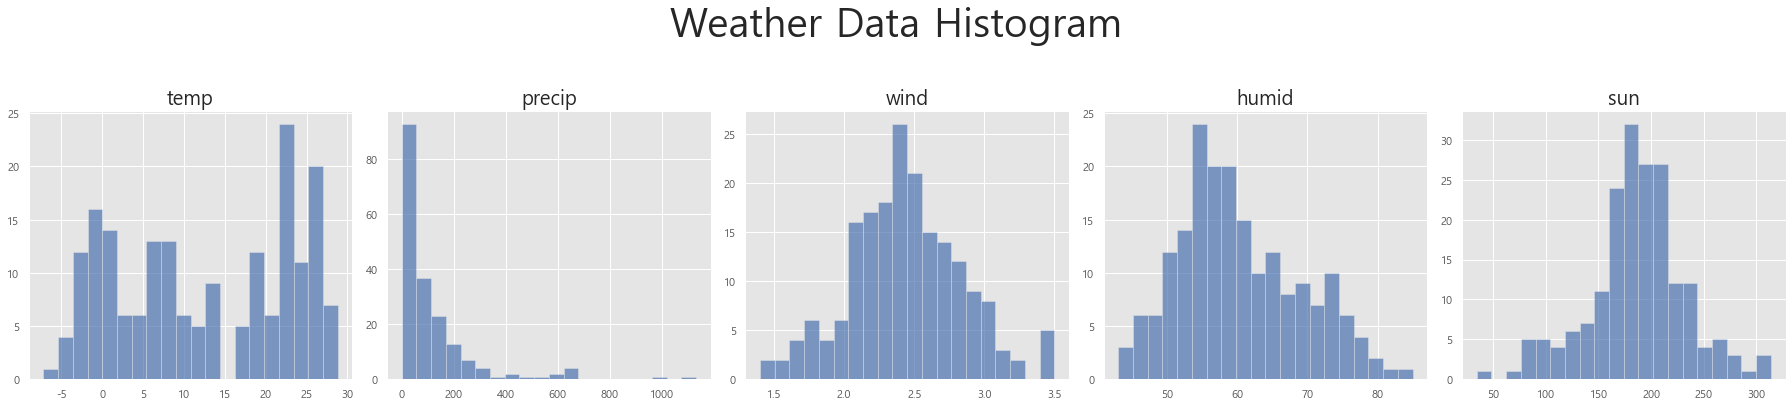

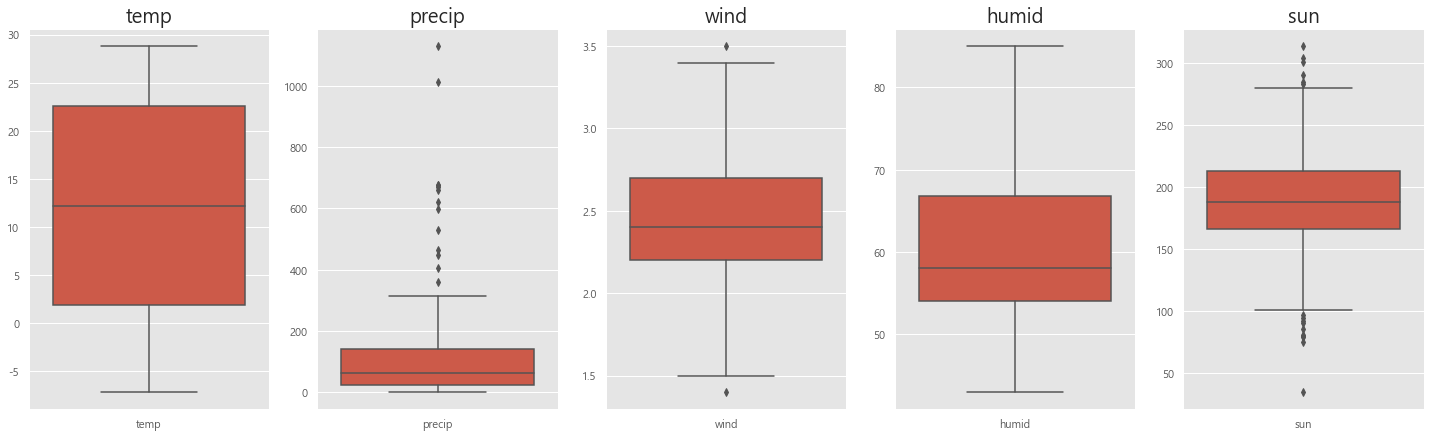

In [7]:
def plot_histogram(df, title: str = "Data Histogram"):

    cols = df.columns
    len_col, len_row = min(len(cols), 5), len(cols)//5 + 1
    plt.style.use("ggplot")
    plt.figure(figsize=(len_col*5, len_row*5))
    plt.suptitle(f"{title}", fontsize=40)

    i=0
    for col in cols:
        if type(df[col][0]) is str:
            continue
        i+=1
        plt.subplot(len_row,len_col,i)
        plt.title(col, fontsize=20)
        if len(df[col].unique()) > 3:
            plt.hist(df[col], bins=20, color='b', alpha=0.7)
        else:
            temp = df[col].value_counts()
            plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
            plt.xticks(temp.keys())
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

product_list = ['Car', 'Electronic','Furniture','Cloth', 'Bag', 'Food','Medicine','Cosmetics', 'Book, Stationery']

# 날씨 데이터 히스토그램
plot_histogram(df_dict[p][['temp', 'precip', 'wind', 'humid', 'sun']], title='Weather Data Histogram')

# box plot
plt.figure(figsize=(25, 7))
for i,c in enumerate(['temp', 'precip', 'wind', 'humid', 'sun']):
    plt.subplot(1,5,i+1)
    plt.title(f"{c}", fontsize=20)
    sns.boxplot(data=df_dict[p][c],)
    plt.xticks(range(1), [c])
plt.show()

제품 별 판매지수 및 판매지수 증감 데이터 히스토그램 분석

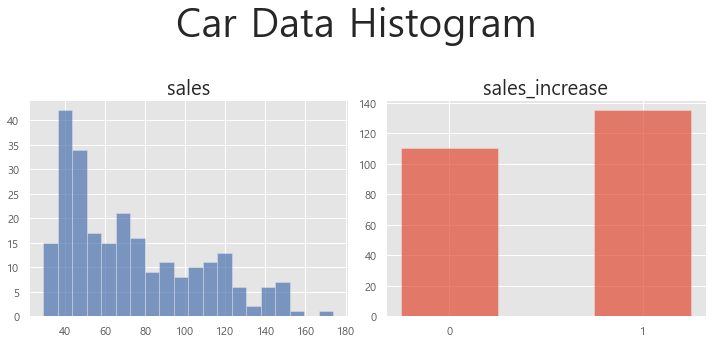

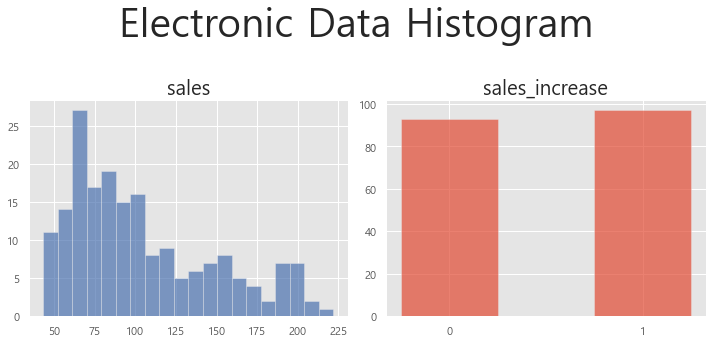

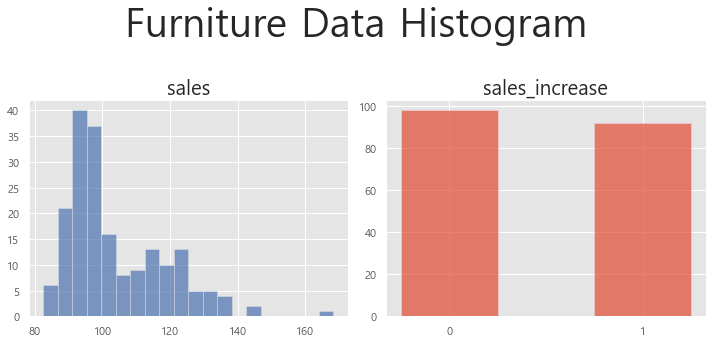

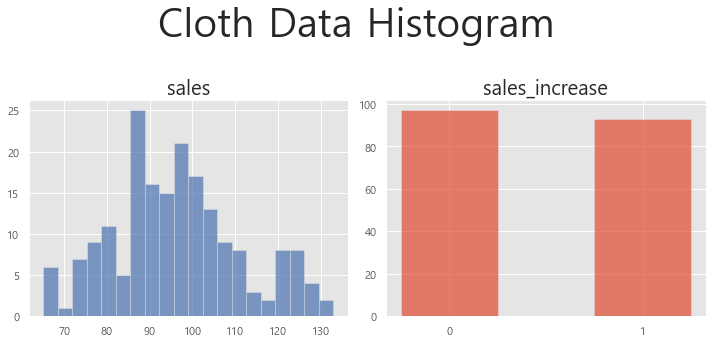

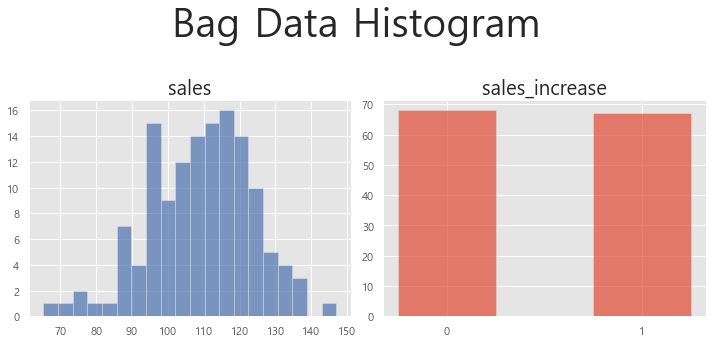

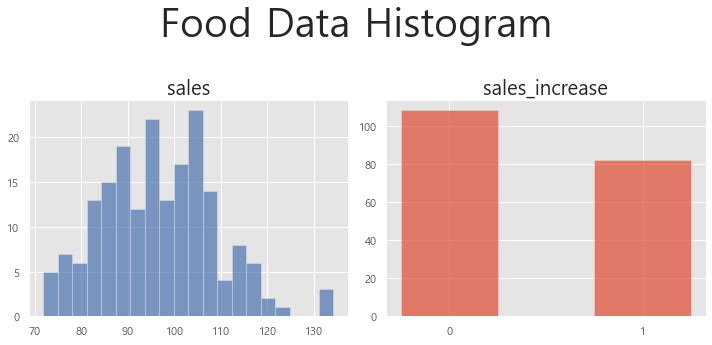

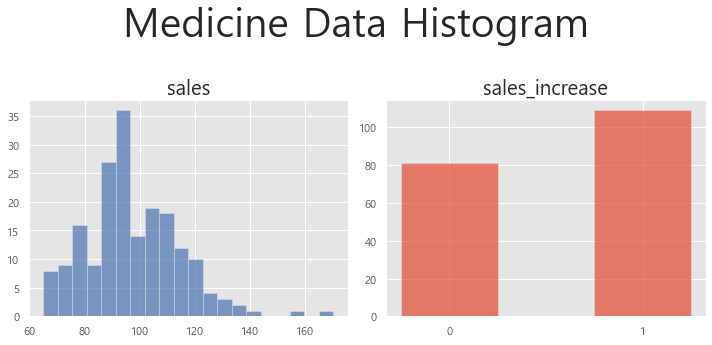

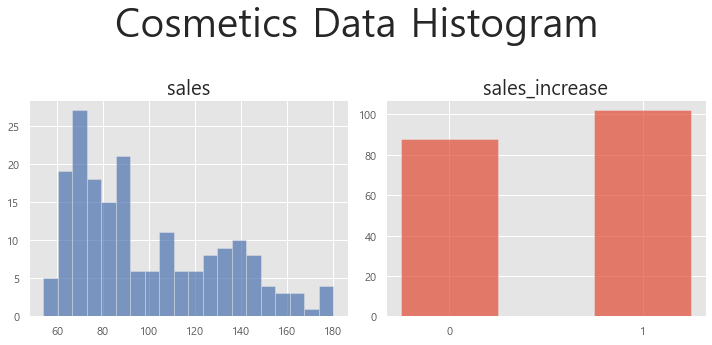

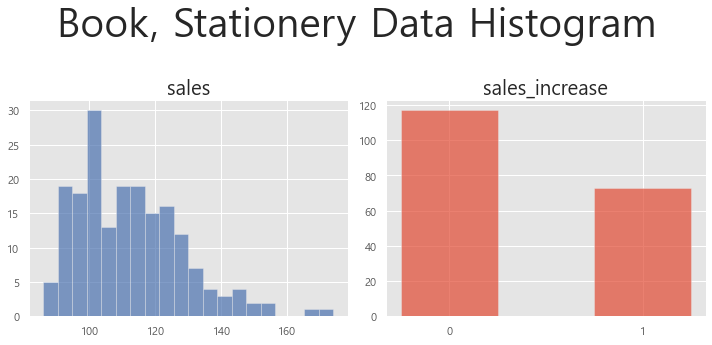

In [8]:
# 판매지수 및 판매지수 증감 데이터 히스토그램
for i,p in enumerate(product_columns):
    plot_histogram(df_dict[p][['sales','sales_increase']], title=f'{product_list[i]} Data Histogram')

판매지수 증감여부에 따른 날씨 데이터 히스토그램

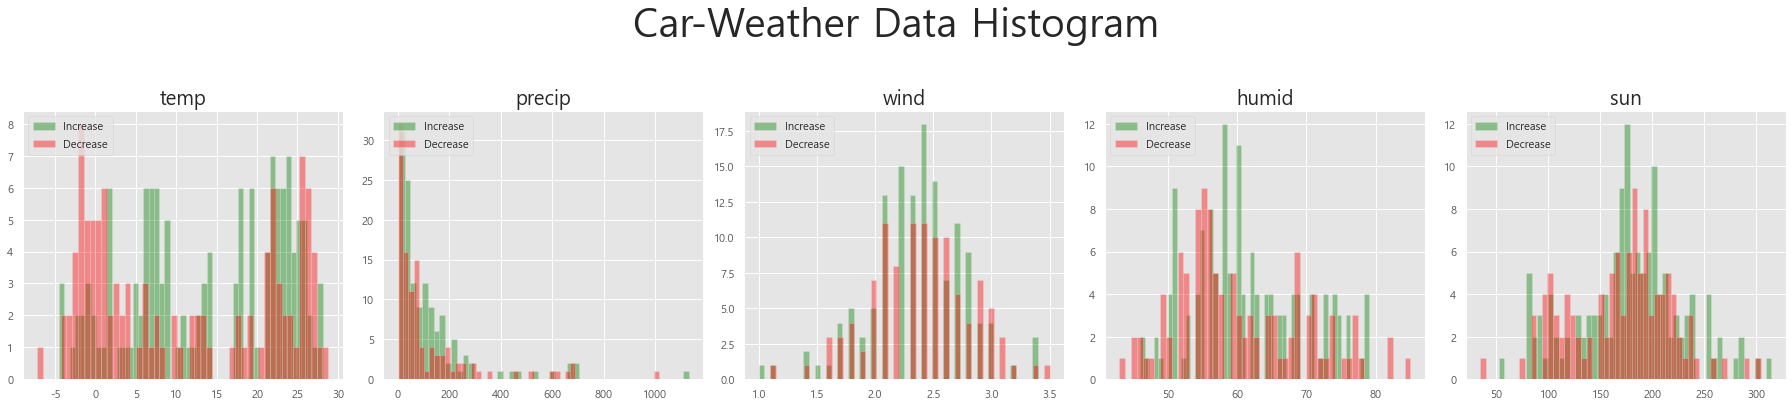

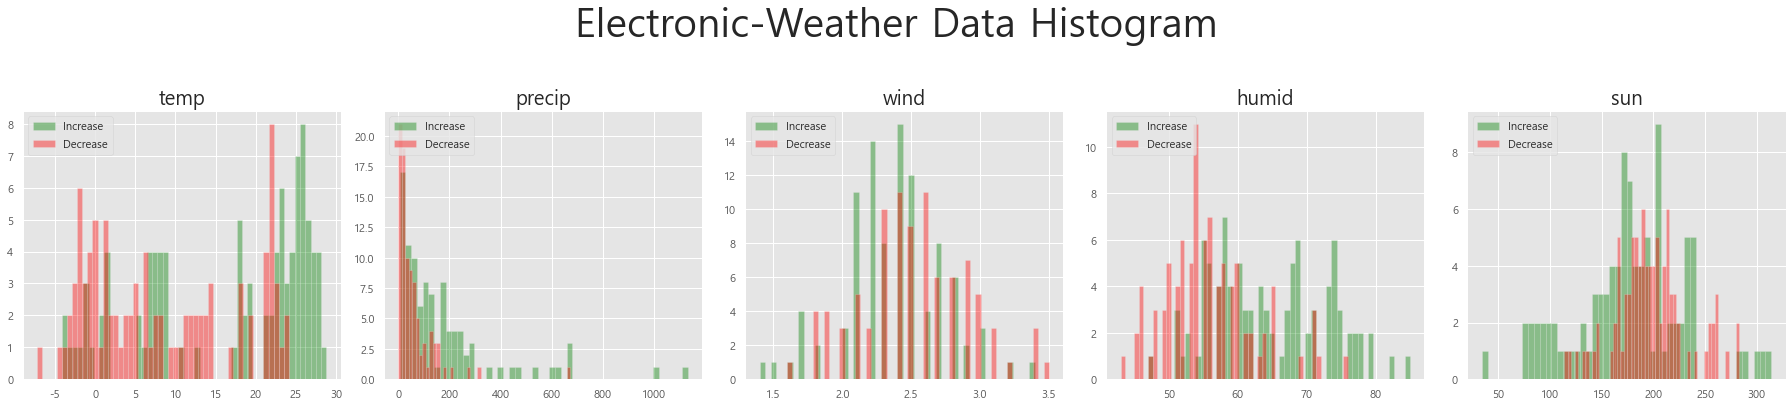

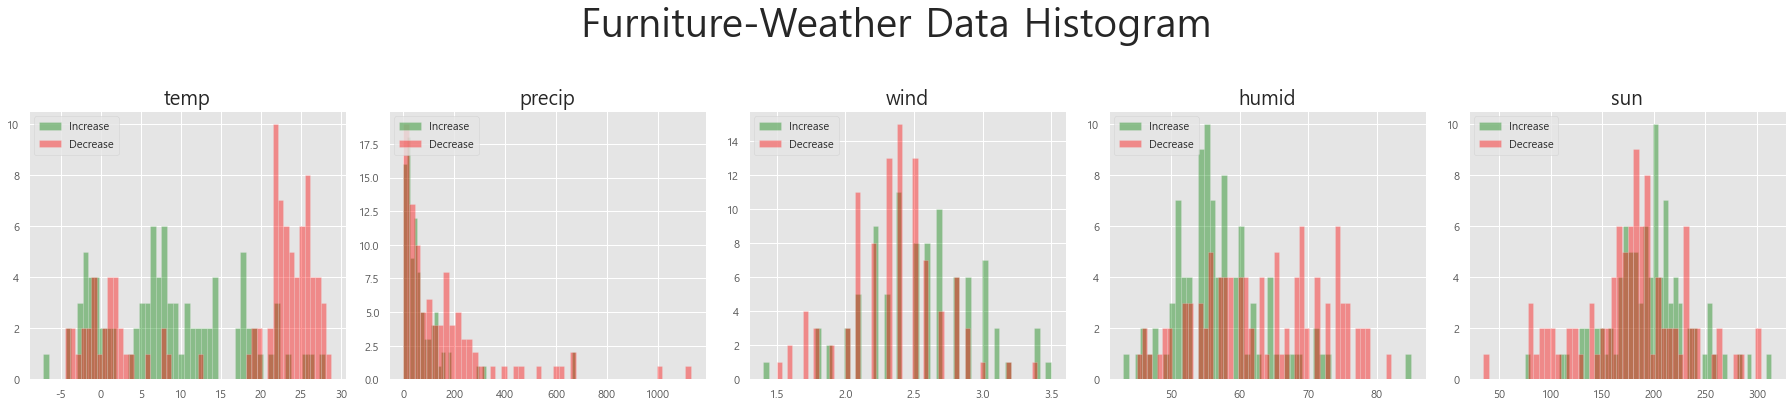

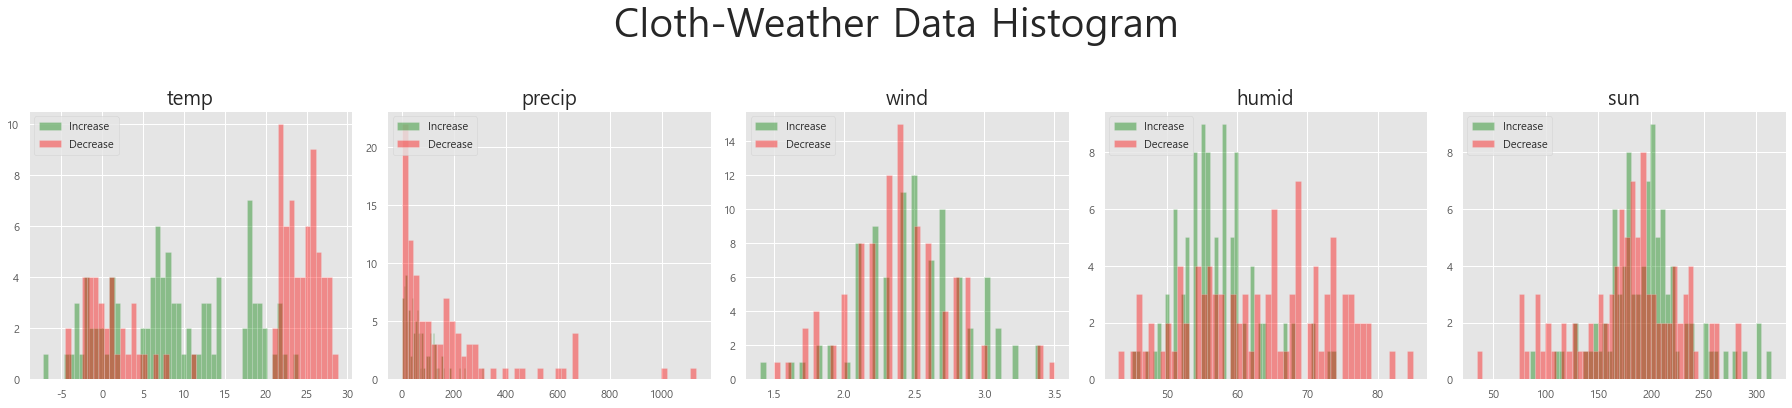

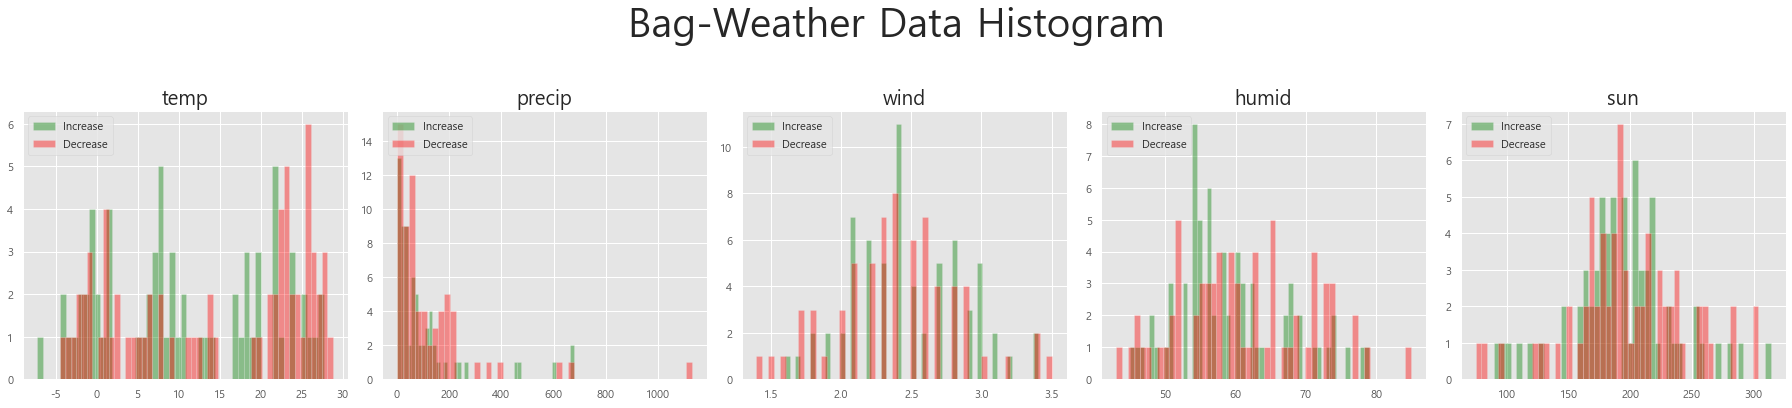

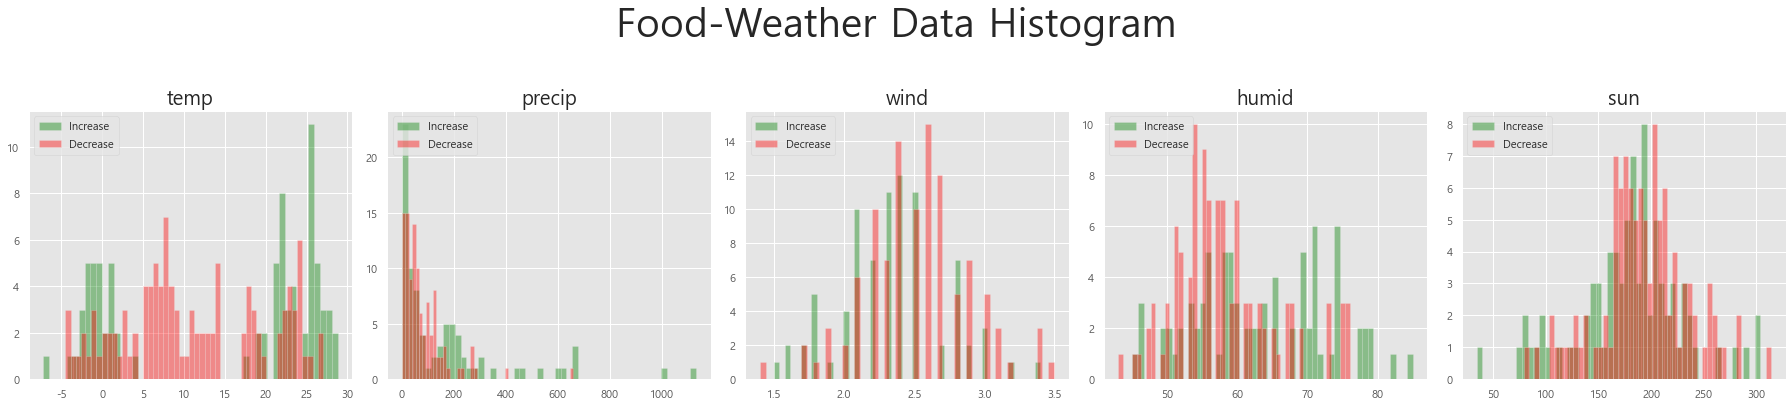

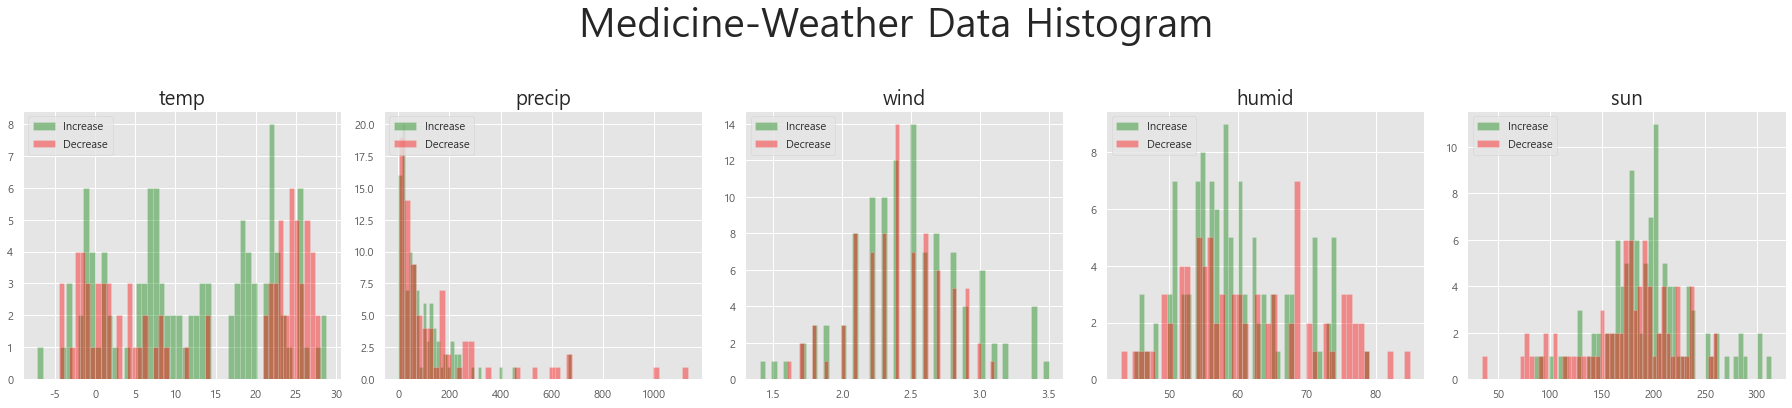

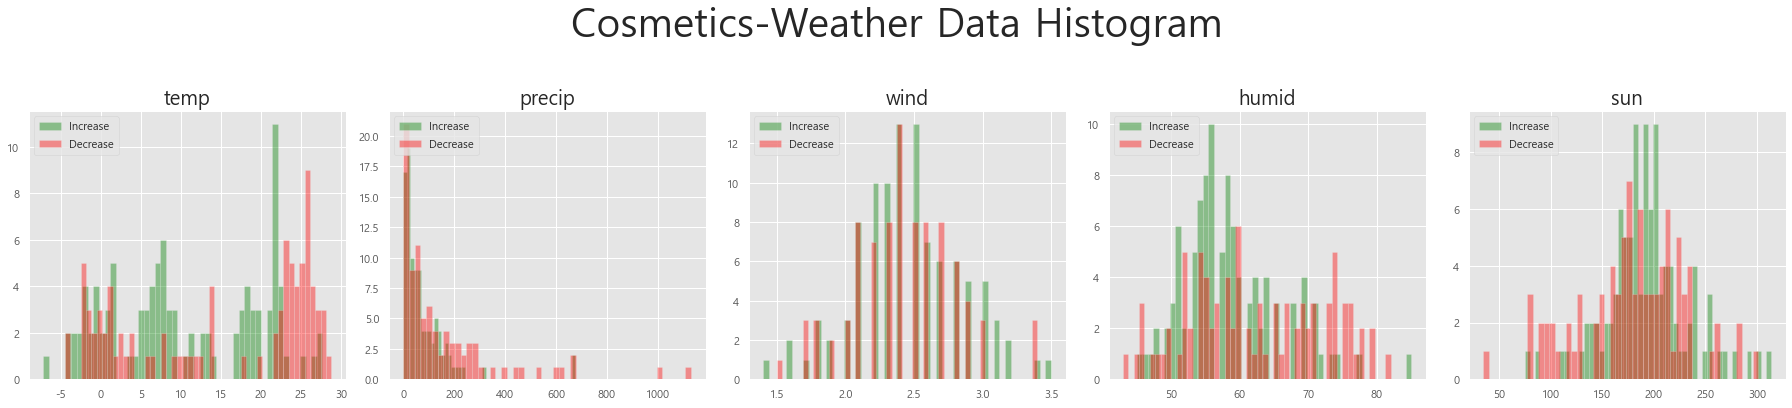

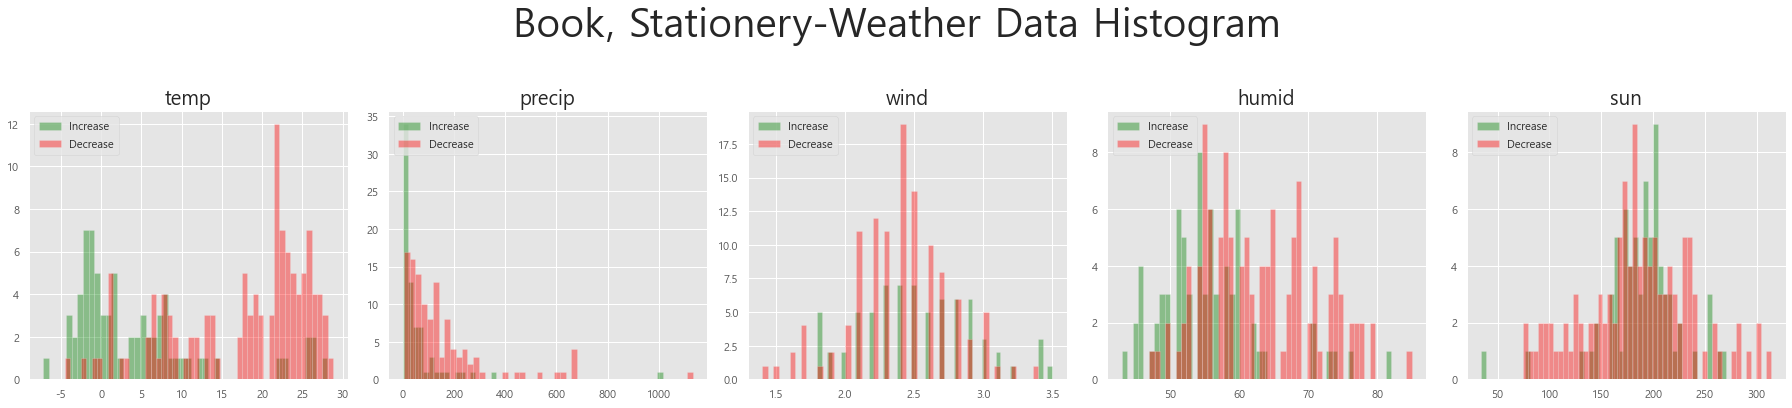

In [9]:
# 판매지수 증감여부에 따른 날씨 데이터 히스토그램 그리기
for i,p in enumerate(product_columns):       
    tmp_increase = df_dict[p].loc[df_dict[p]['sales_increase']==1][['temp','precip', 'wind', 'humid', 'sun']]
    tmp_decrease = df_dict[p].loc[df_dict[p]['sales_increase']==0][['temp','precip', 'wind', 'humid', 'sun']]
    
    cols = tmp_increase.columns
    len_col, len_row = min(len(cols), 5), len(cols)//5 + 1
    
    plt.figure(figsize=(len_col*5, len_row*5))
    plt.suptitle(f"{product_list[i]}-Weather Data Histogram", fontsize=40)
    
    j=0
    for col in tmp_increase.columns:
        j+=1
        plt.subplot(len_row,len_col,j)
        plt.title(col, fontsize=20)
        plt.hist(tmp_increase[col], color = 'green', alpha = 0.4, bins = 50, label='Increase')
        plt.hist(tmp_decrease[col], color = 'red', alpha = 0.4, bins = 50, label='Decrease')
        plt.legend(loc='upper left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt. show()

Outlier 데이터 제거

In [10]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

# 함수 사용해서 이상치 값 삭제
for i,p in enumerate(product_columns):
    for c in list(df_dict[p].iloc[:,1:-2].columns):
        outlier_idx = get_outlier(df=df_dict[p].iloc[:,1:-2].apply(pd.to_numeric), column = c, weight=1.5)
        df_dict[p].drop(outlier_idx, axis=0, inplace=True)
    print(f'상품군 {p}의 데이터 크기 : {df_dict[p].shape}')


상품군 승용차의 데이터 크기 : (215, 8)
상품군 가전제품의 데이터 크기 : (161, 8)
상품군 가구의 데이터 크기 : (161, 8)
상품군 의복의 데이터 크기 : (161, 8)
상품군 가방의 데이터 크기 : (116, 8)
상품군 음식료품의 데이터 크기 : (161, 8)
상품군 의약품의 데이터 크기 : (161, 8)
상품군 화장품의 데이터 크기 : (161, 8)
상품군 서적, 문구의 데이터 크기 : (161, 8)


### (2) 변수간 상관관계 확인

각 제품 별 날씨와의 히트맵 분석

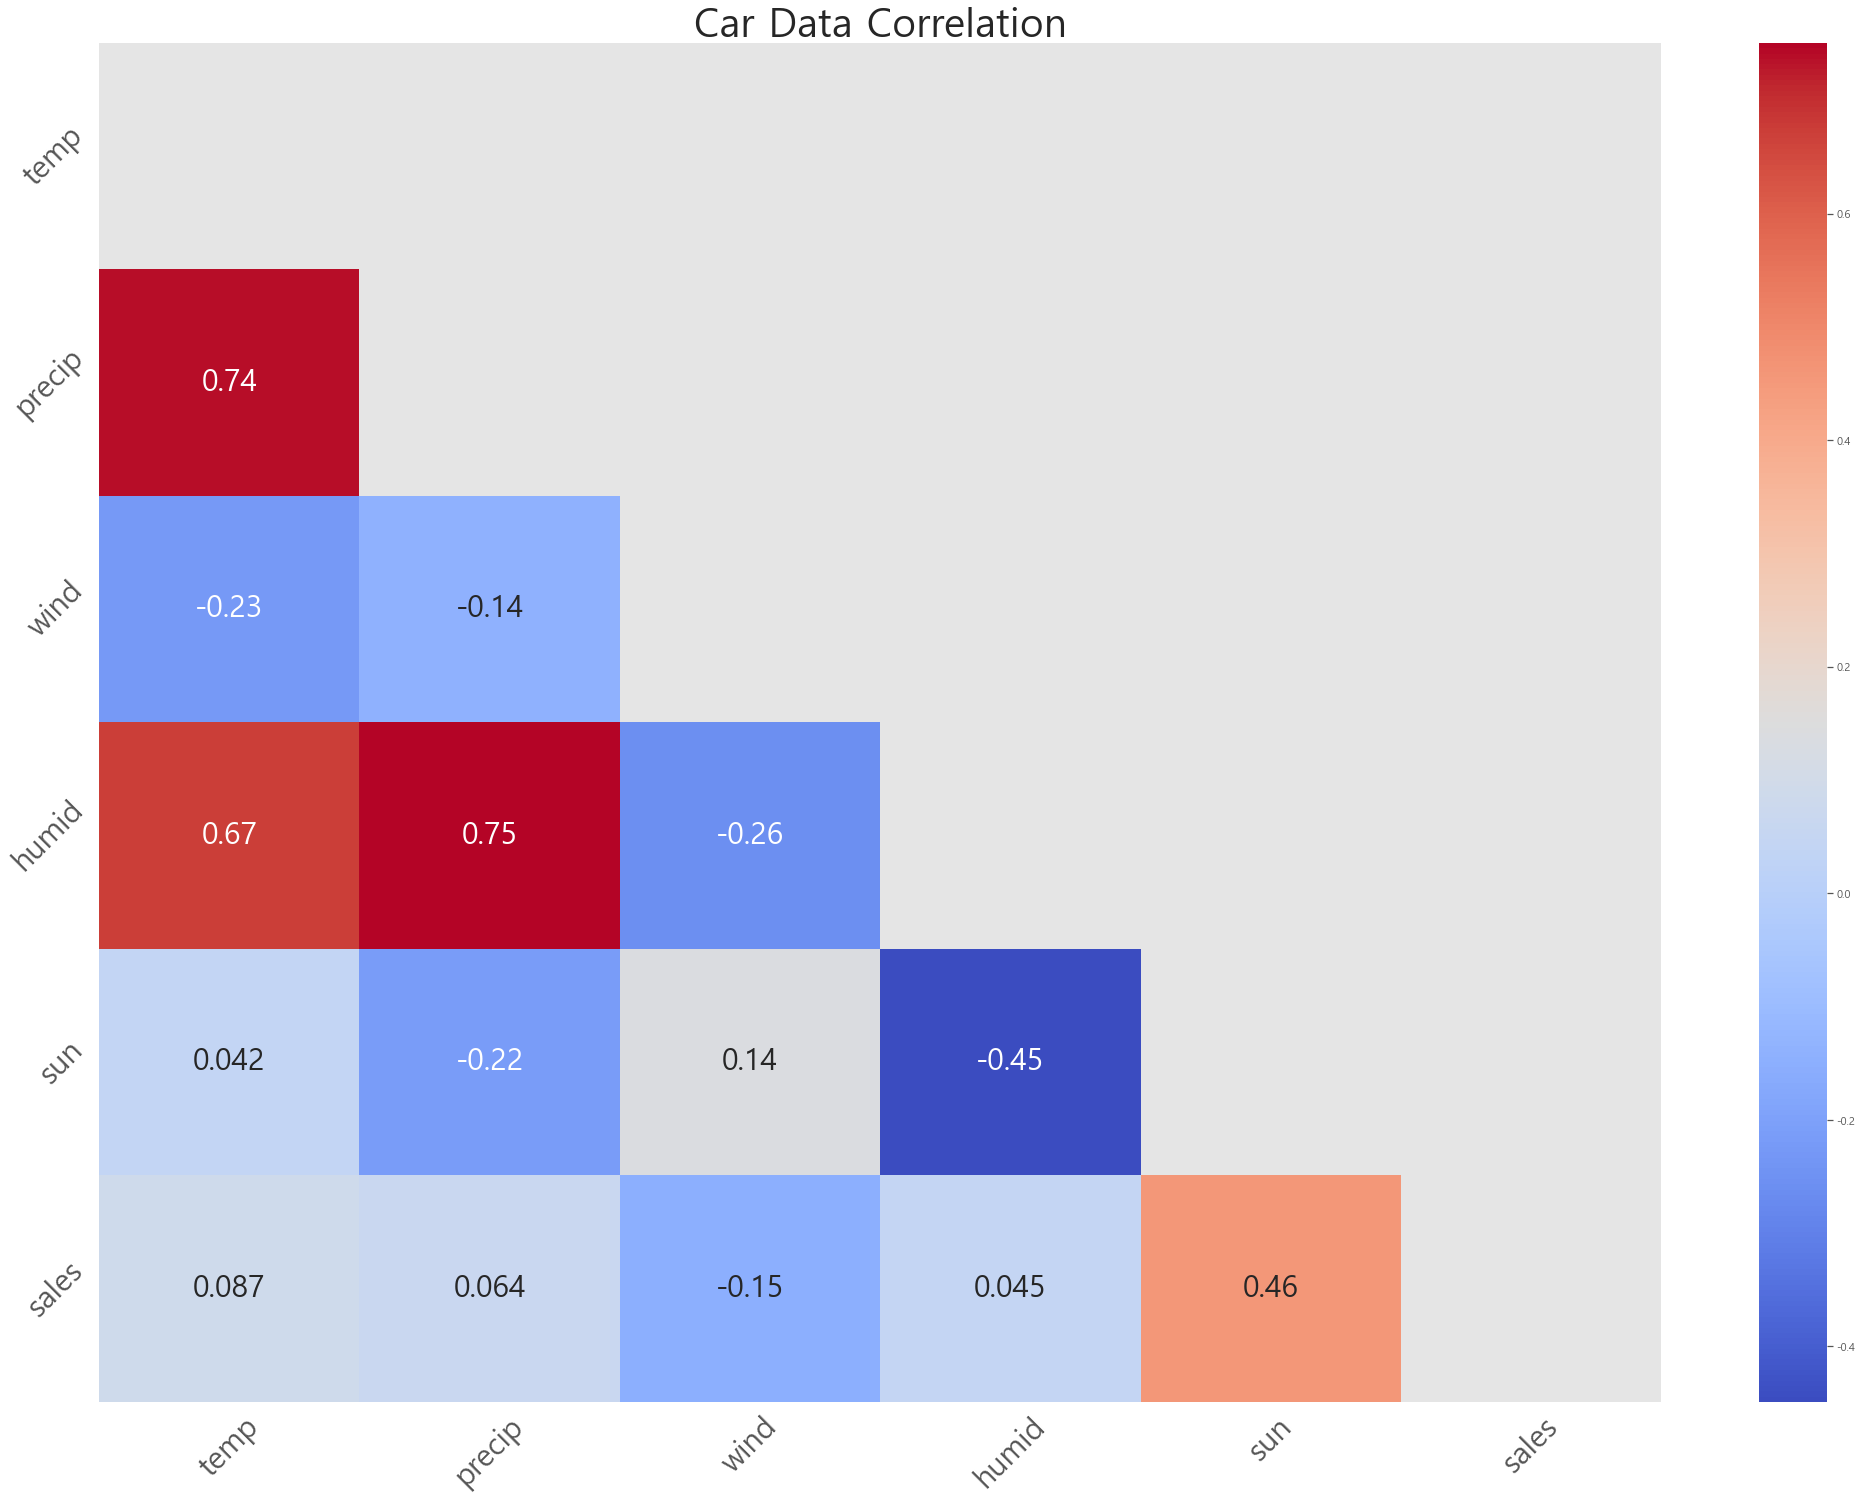

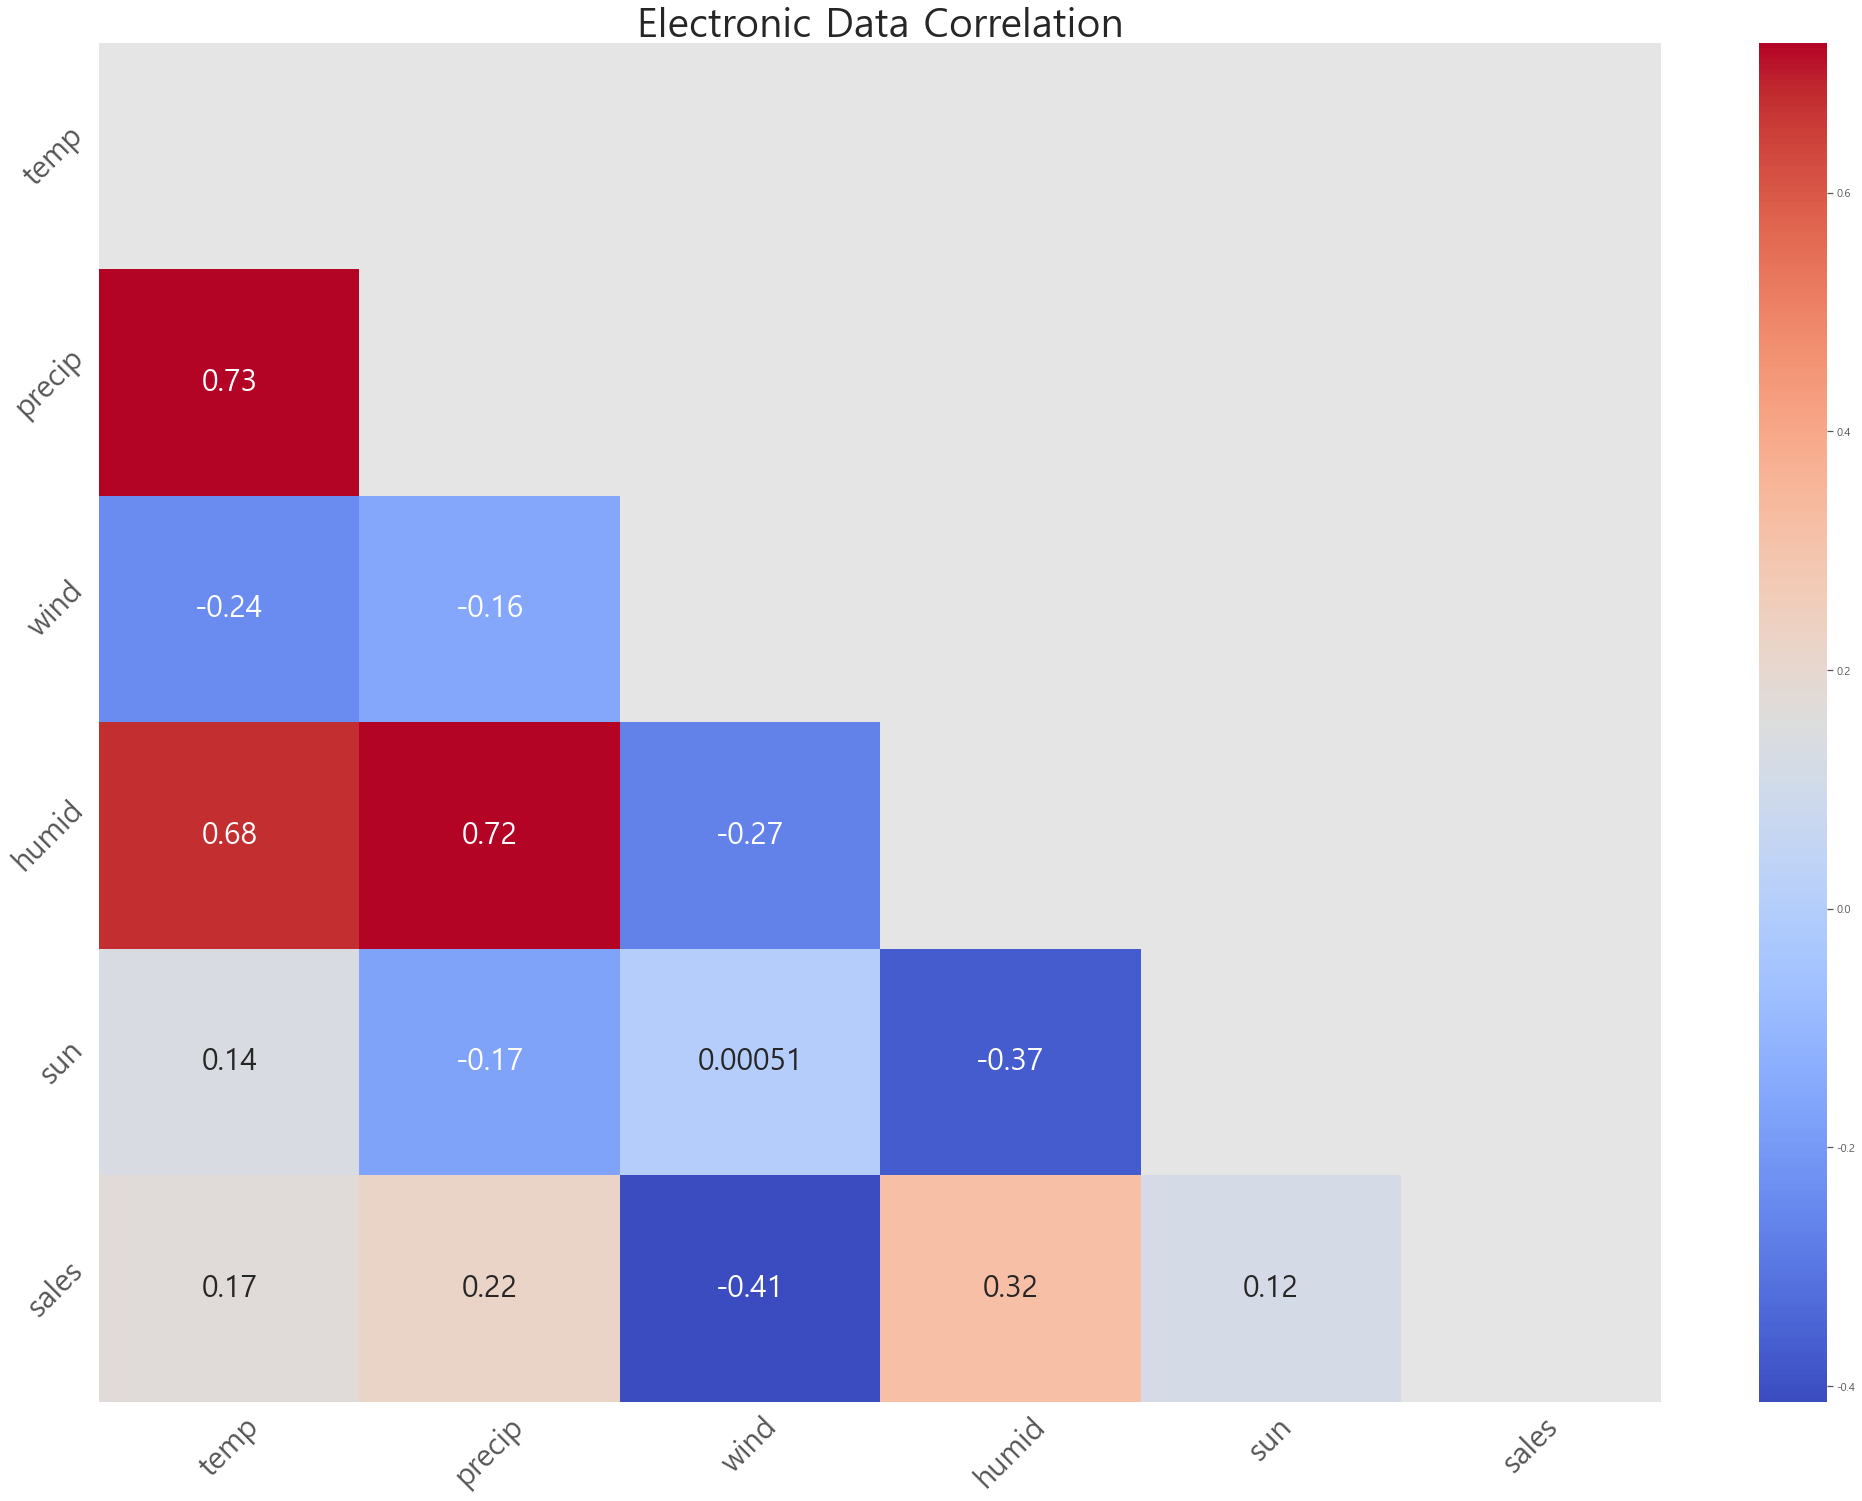

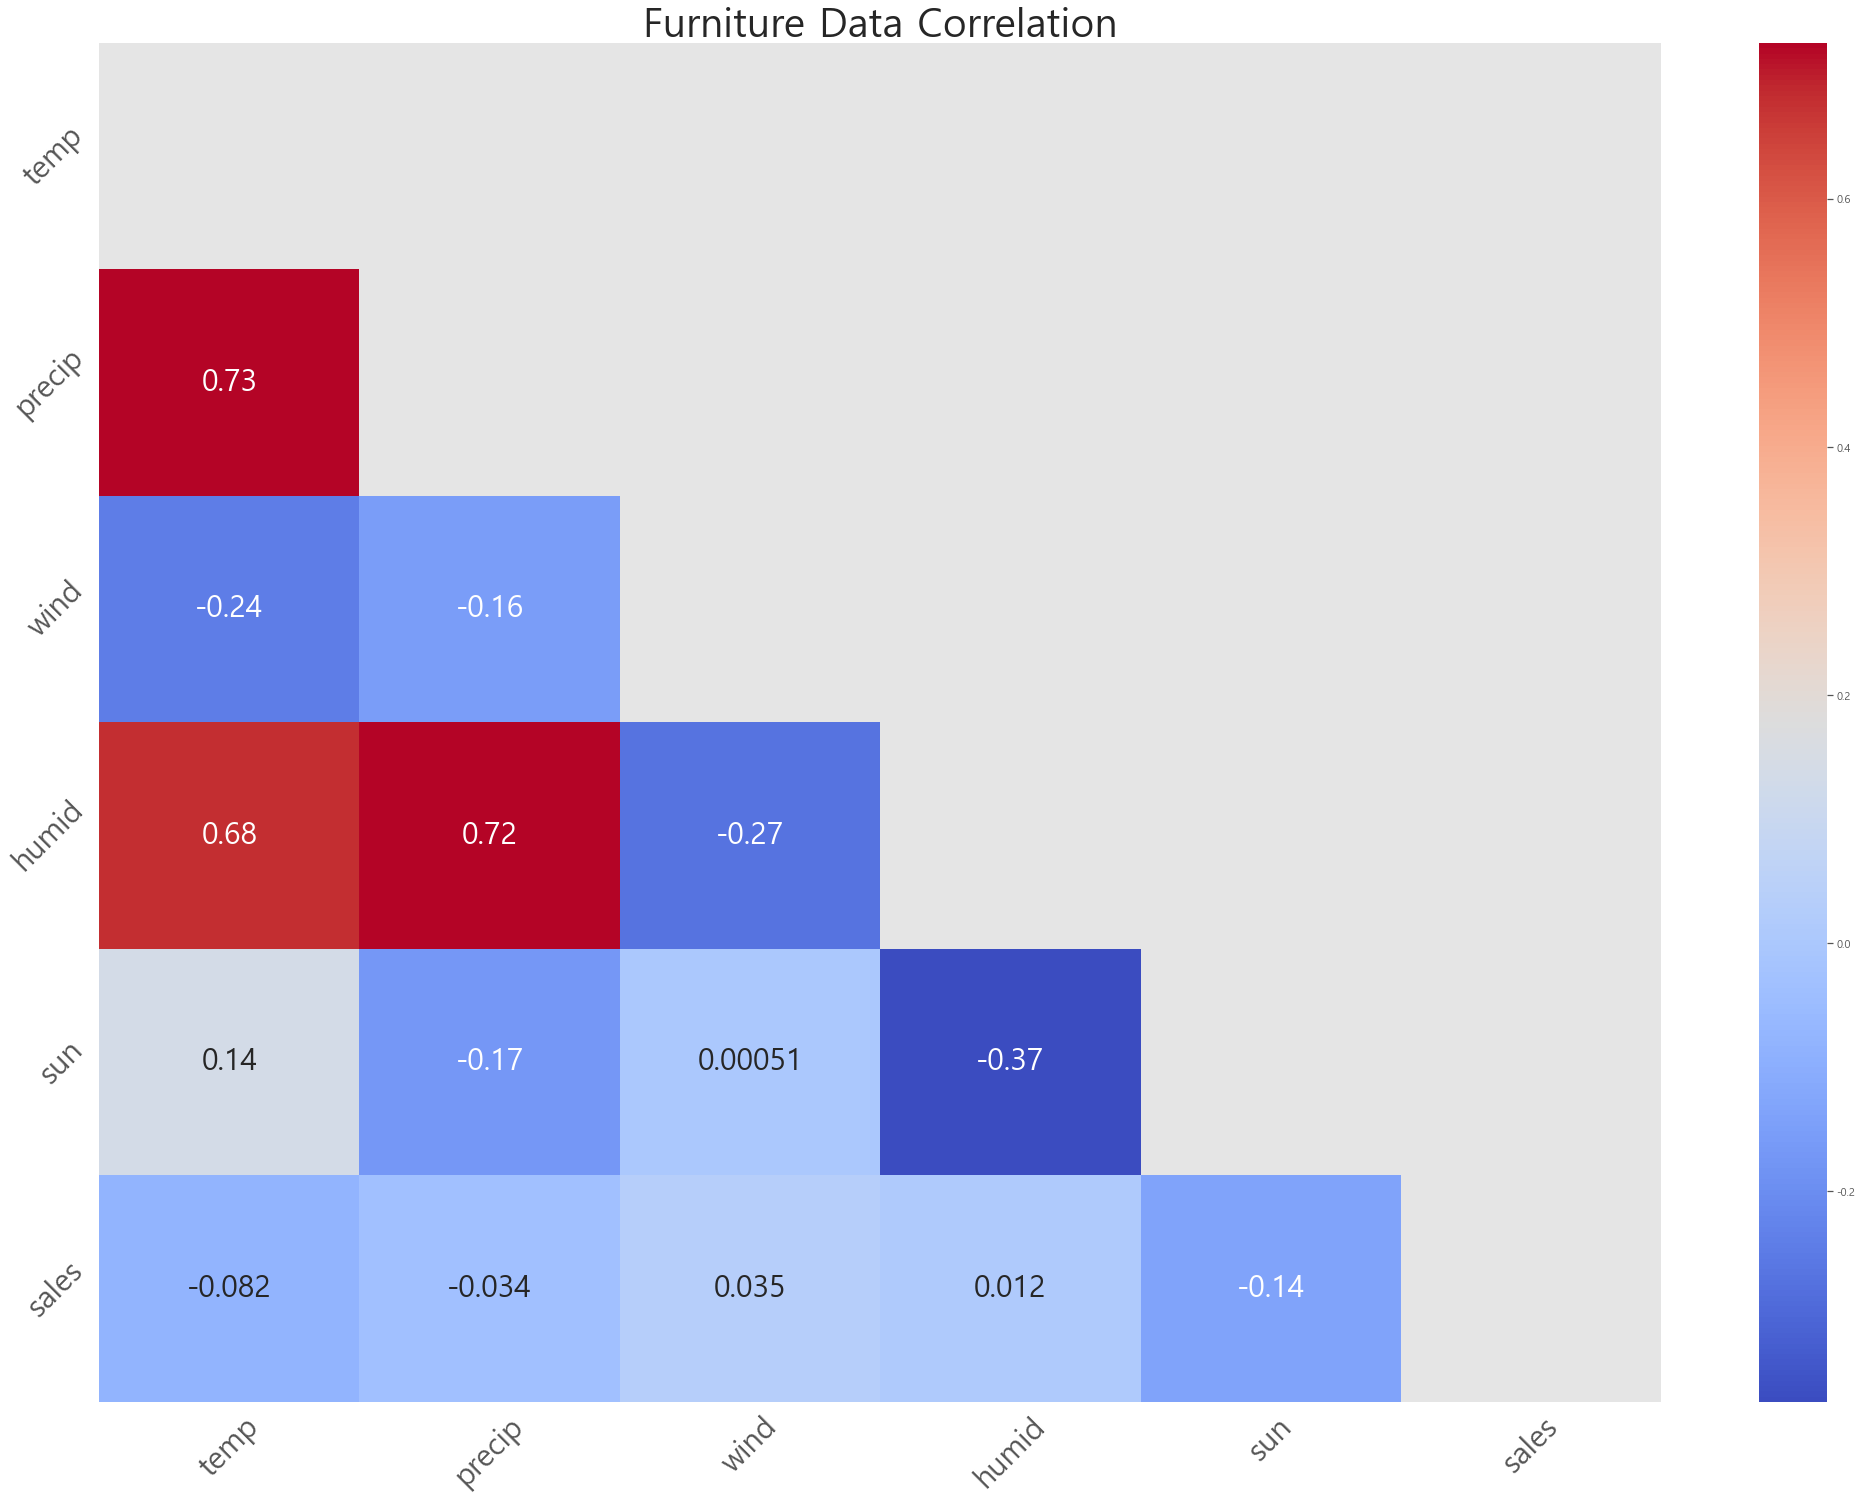

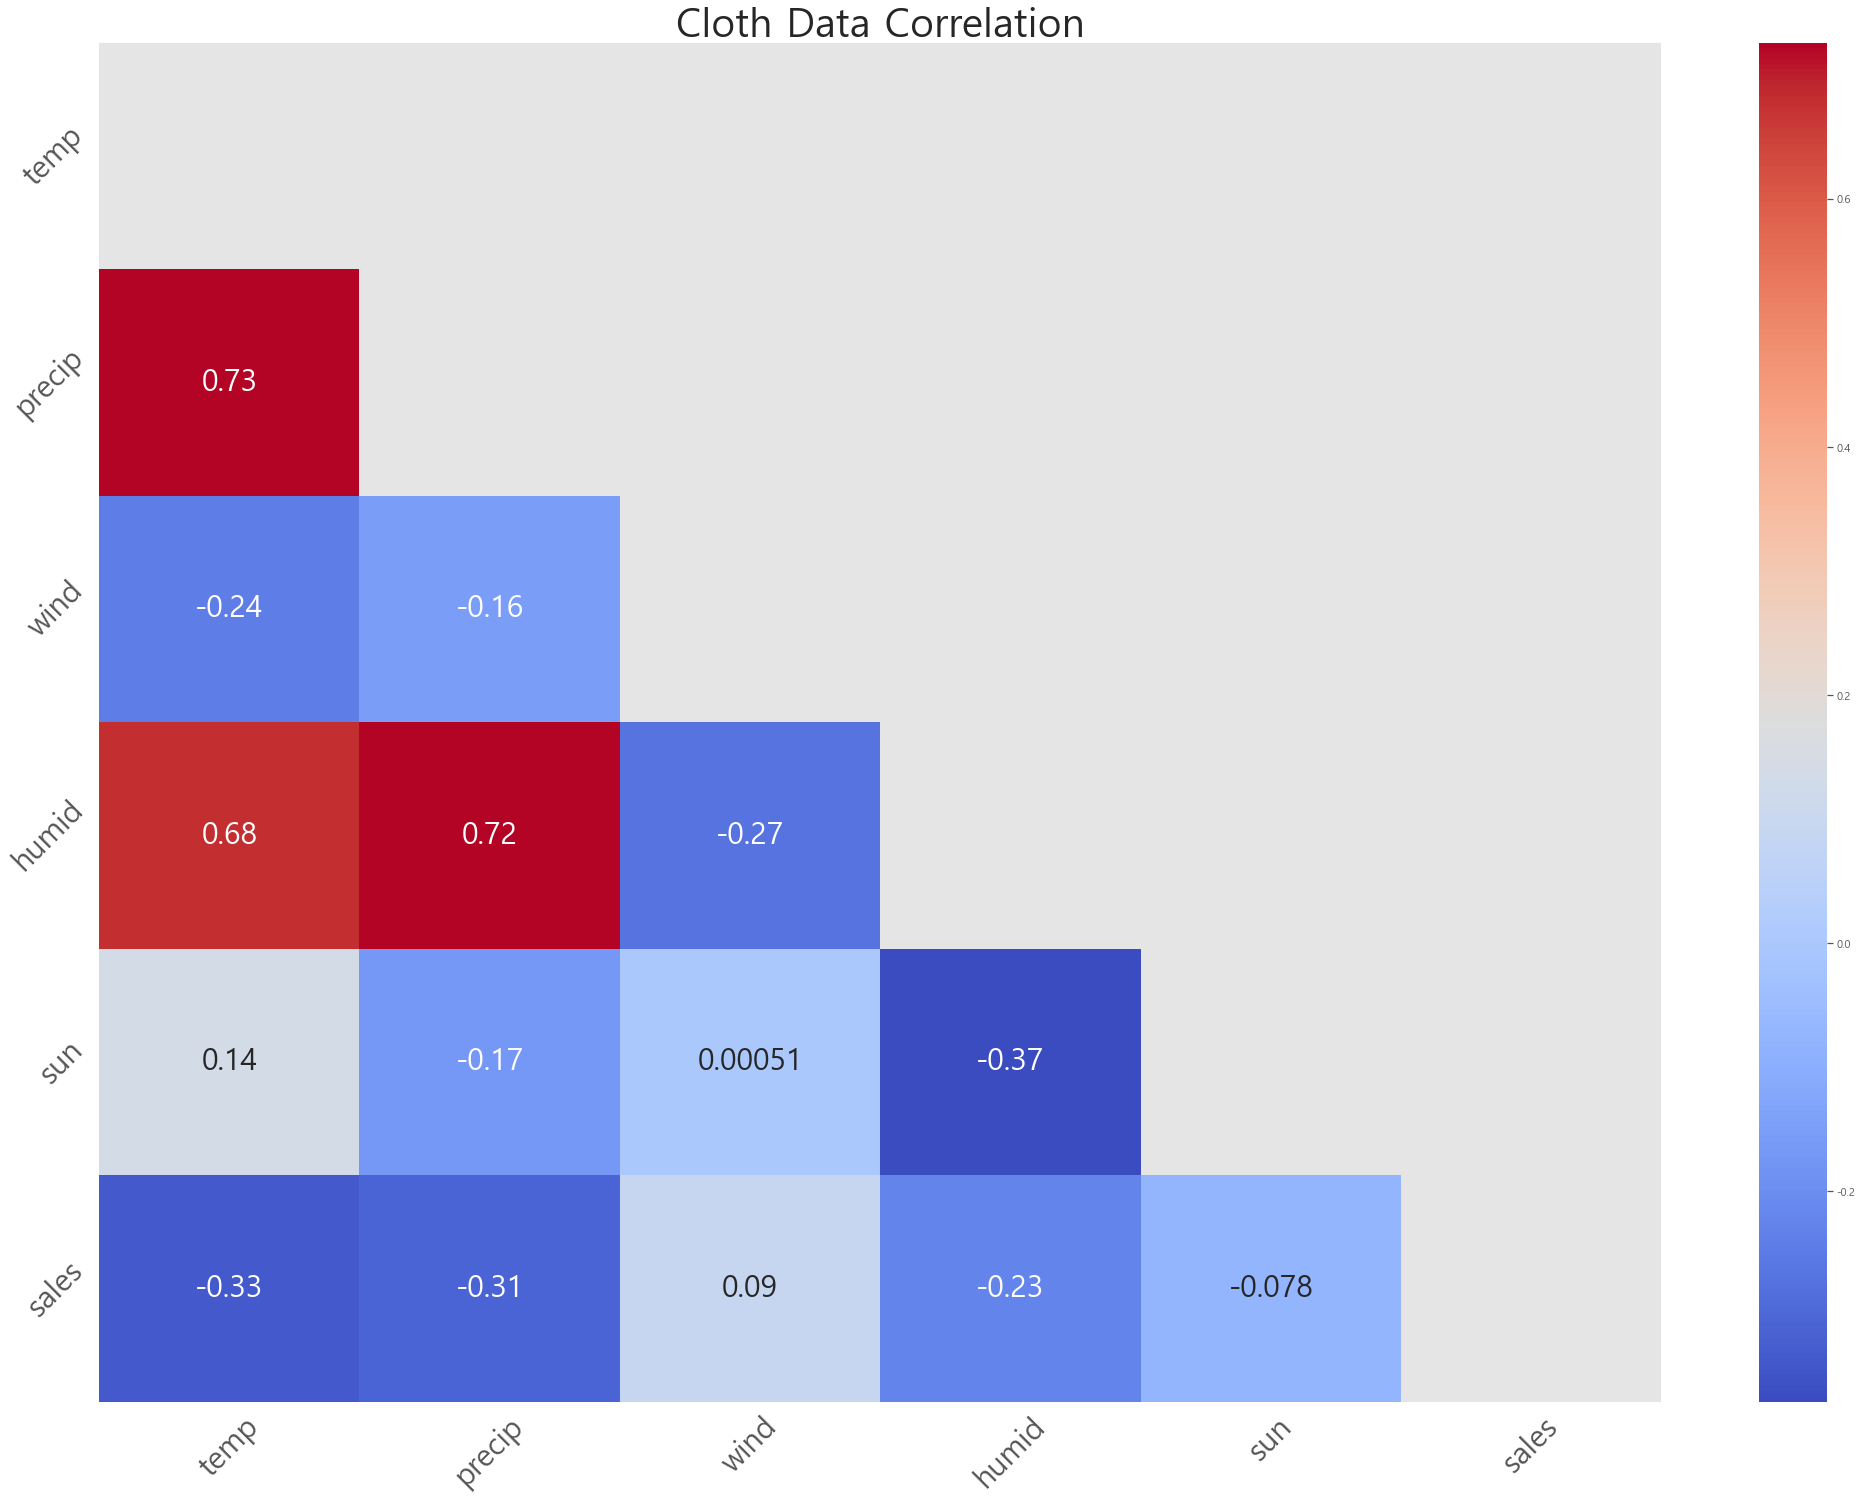

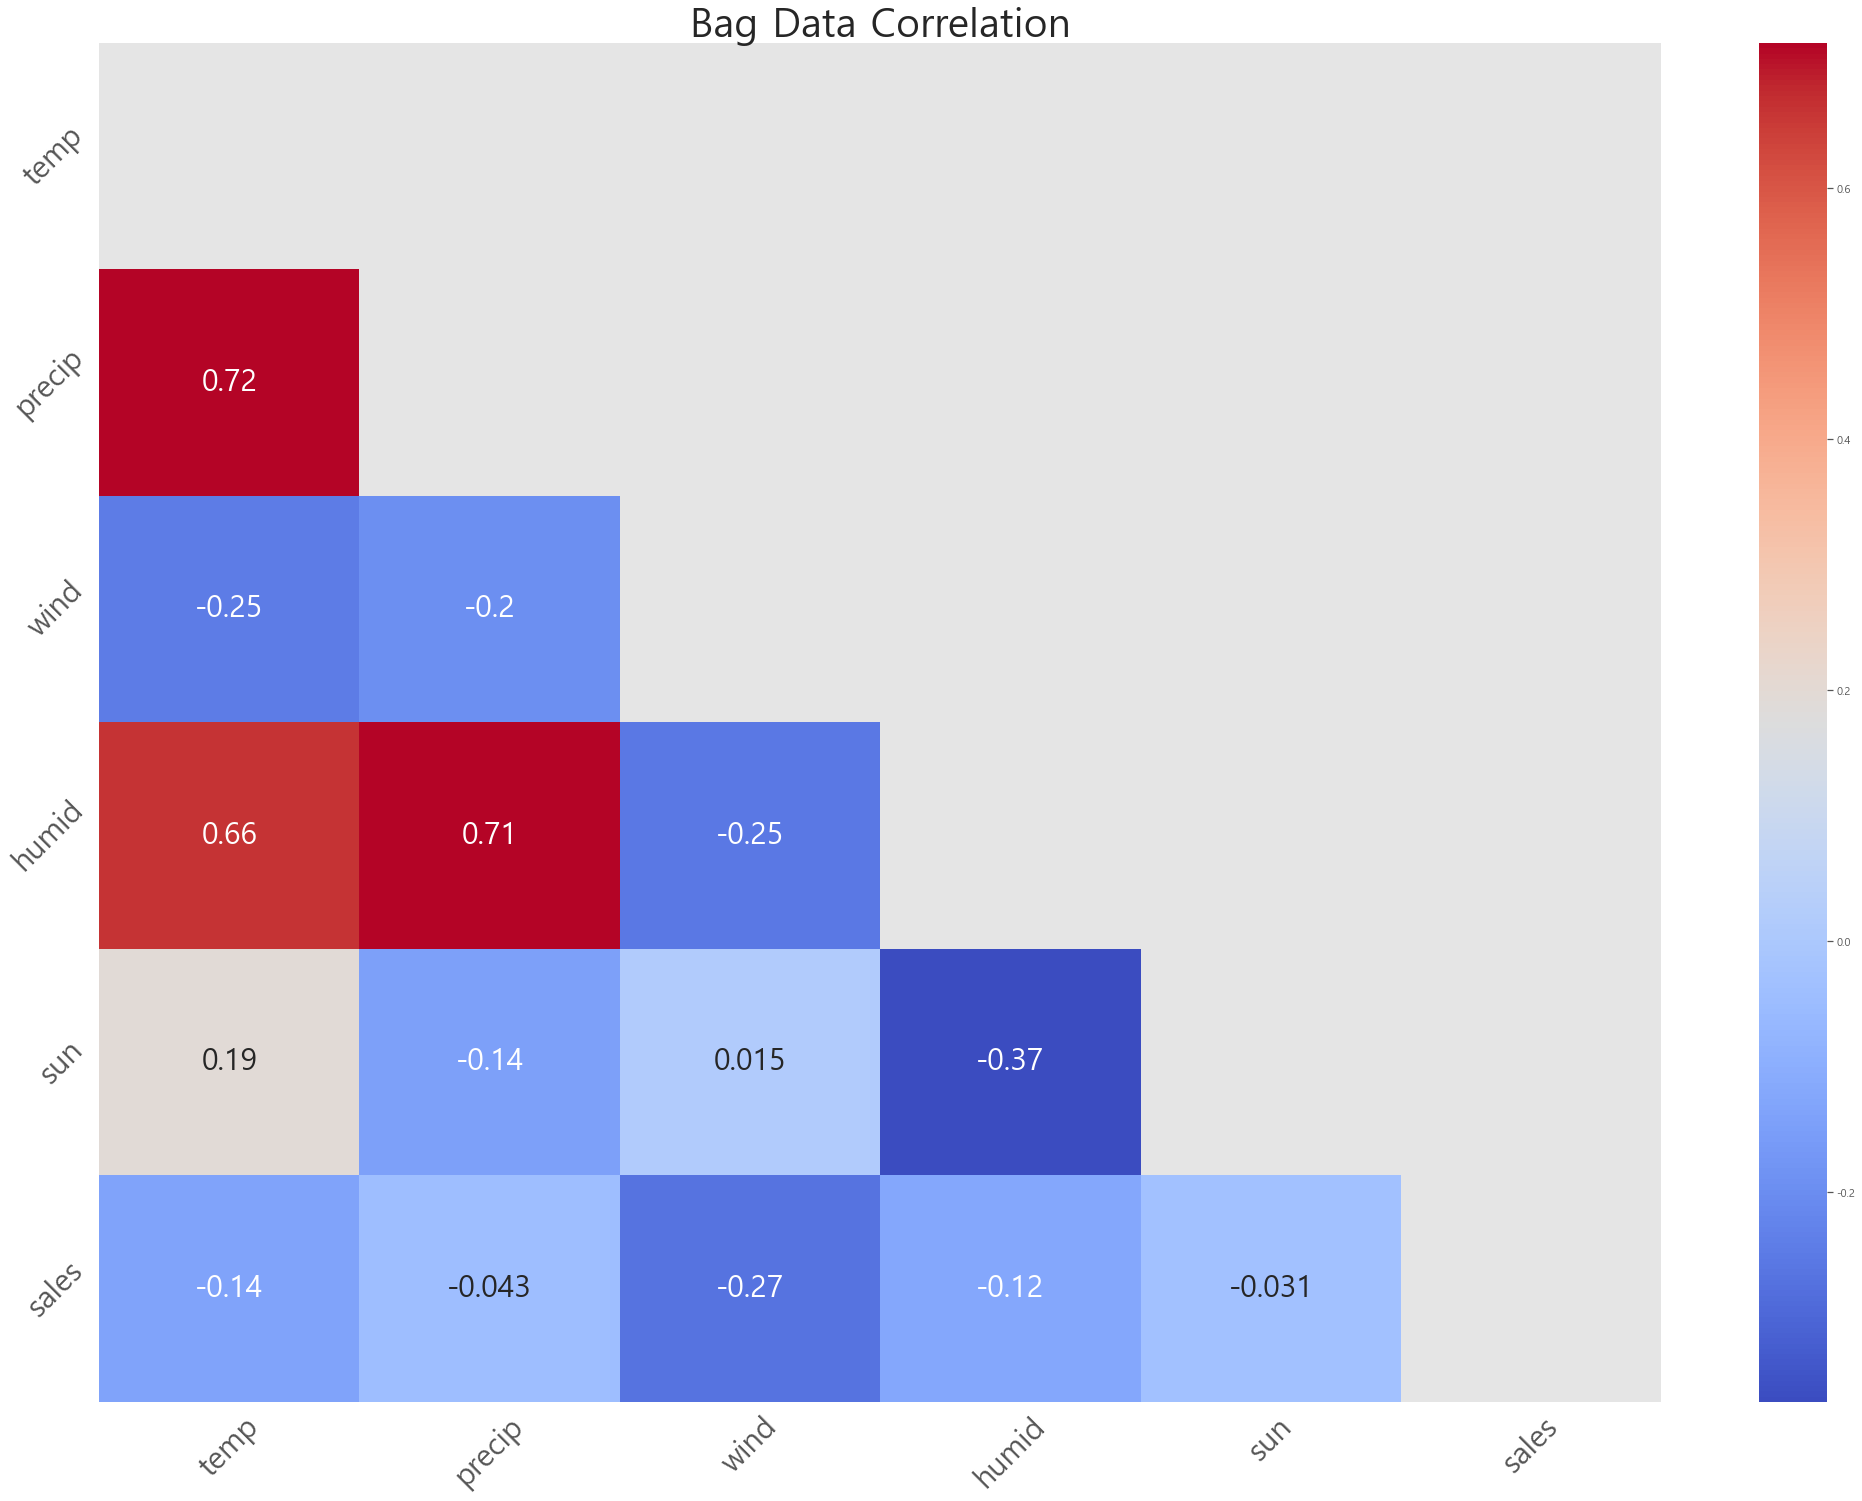

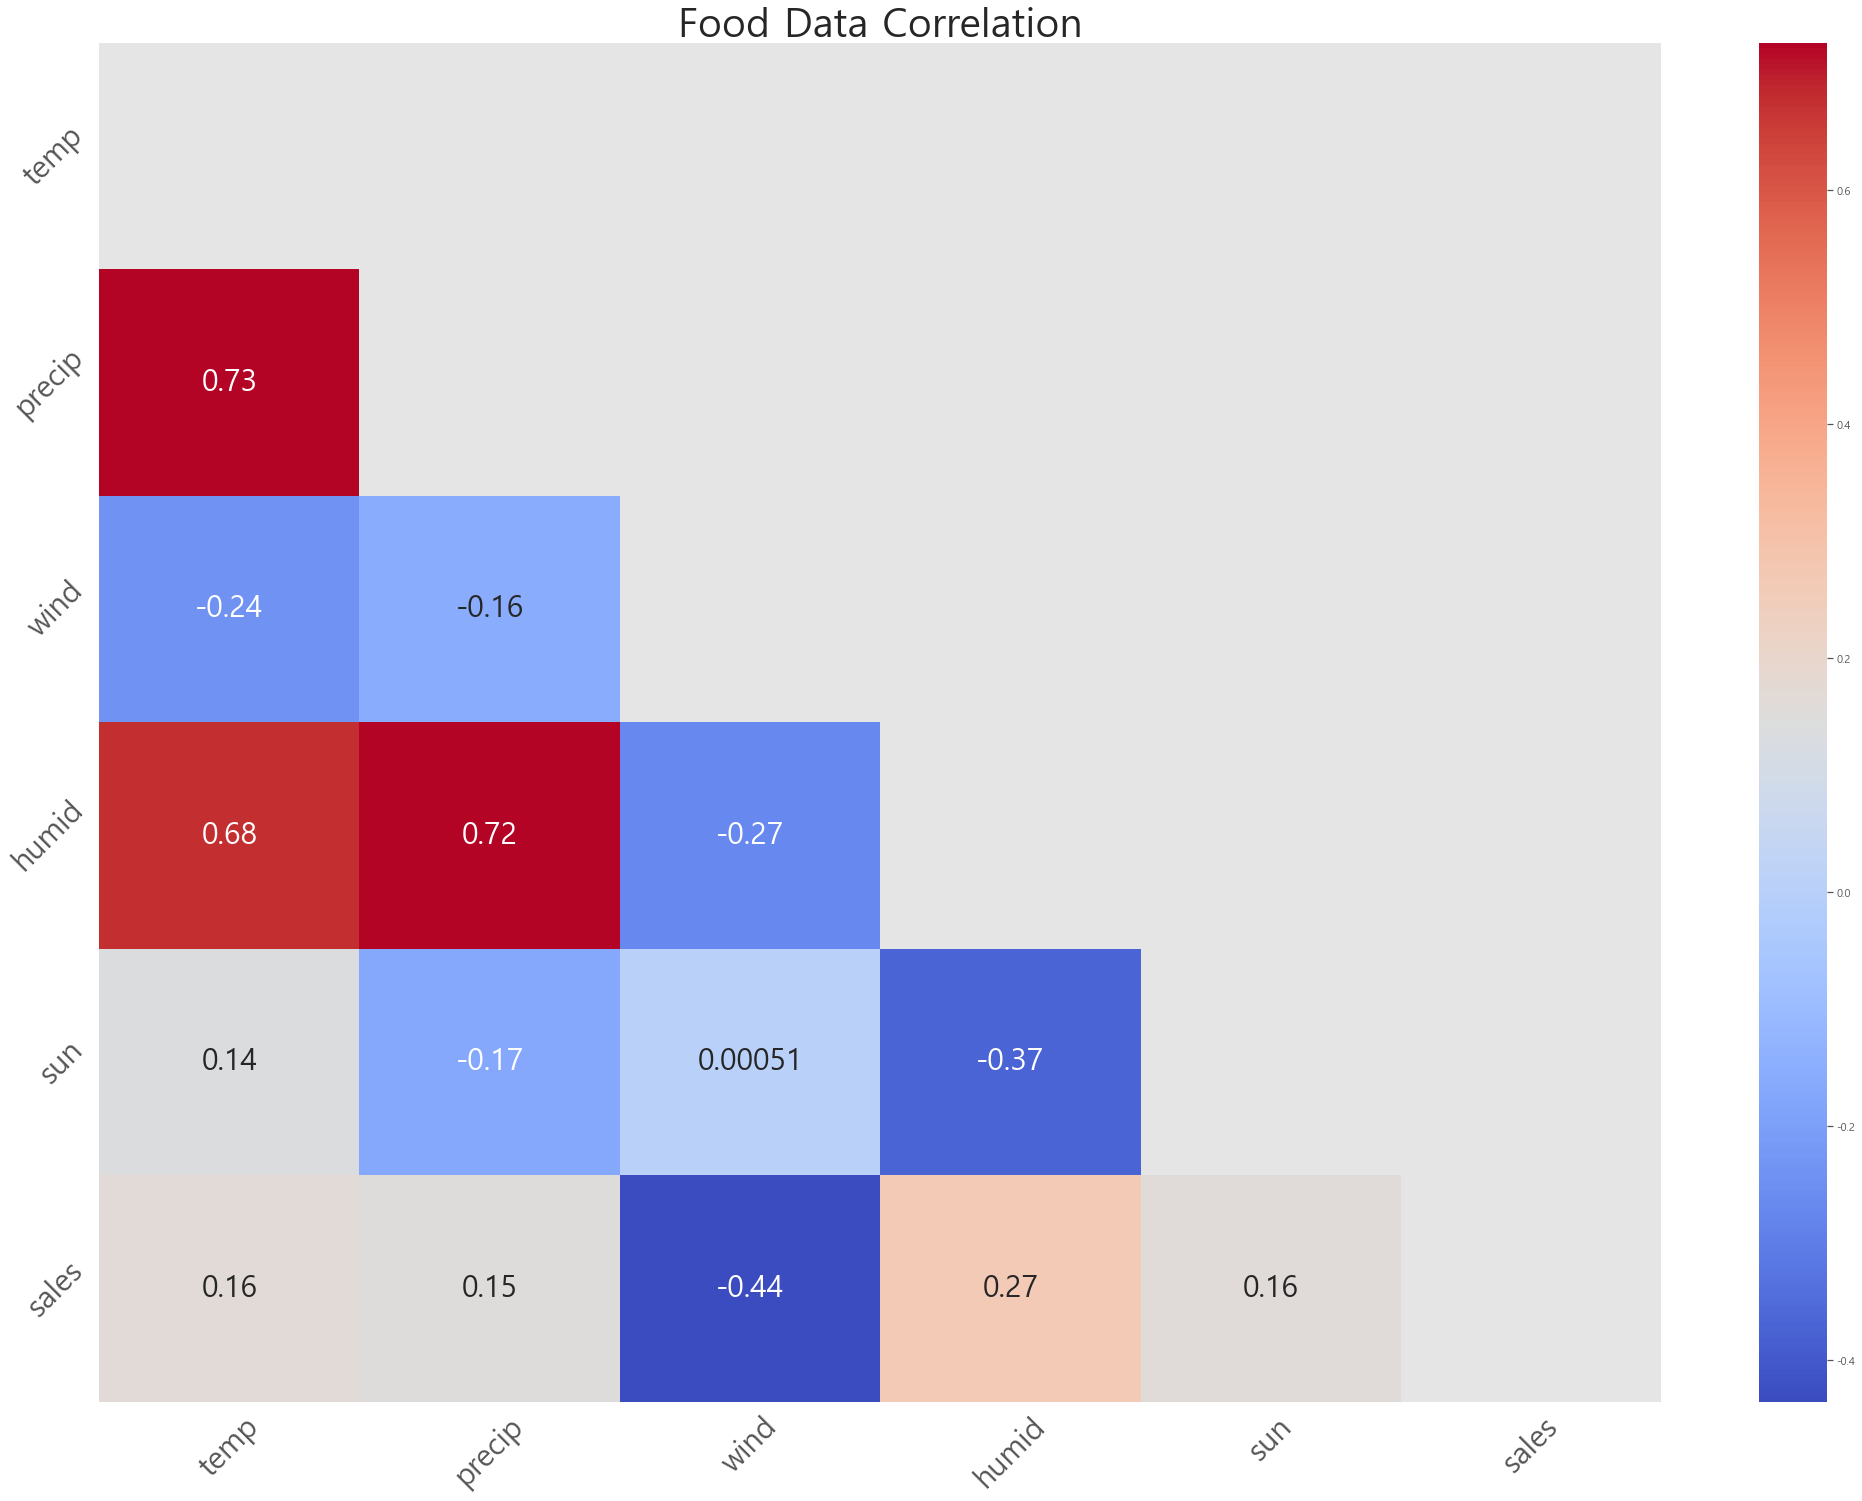

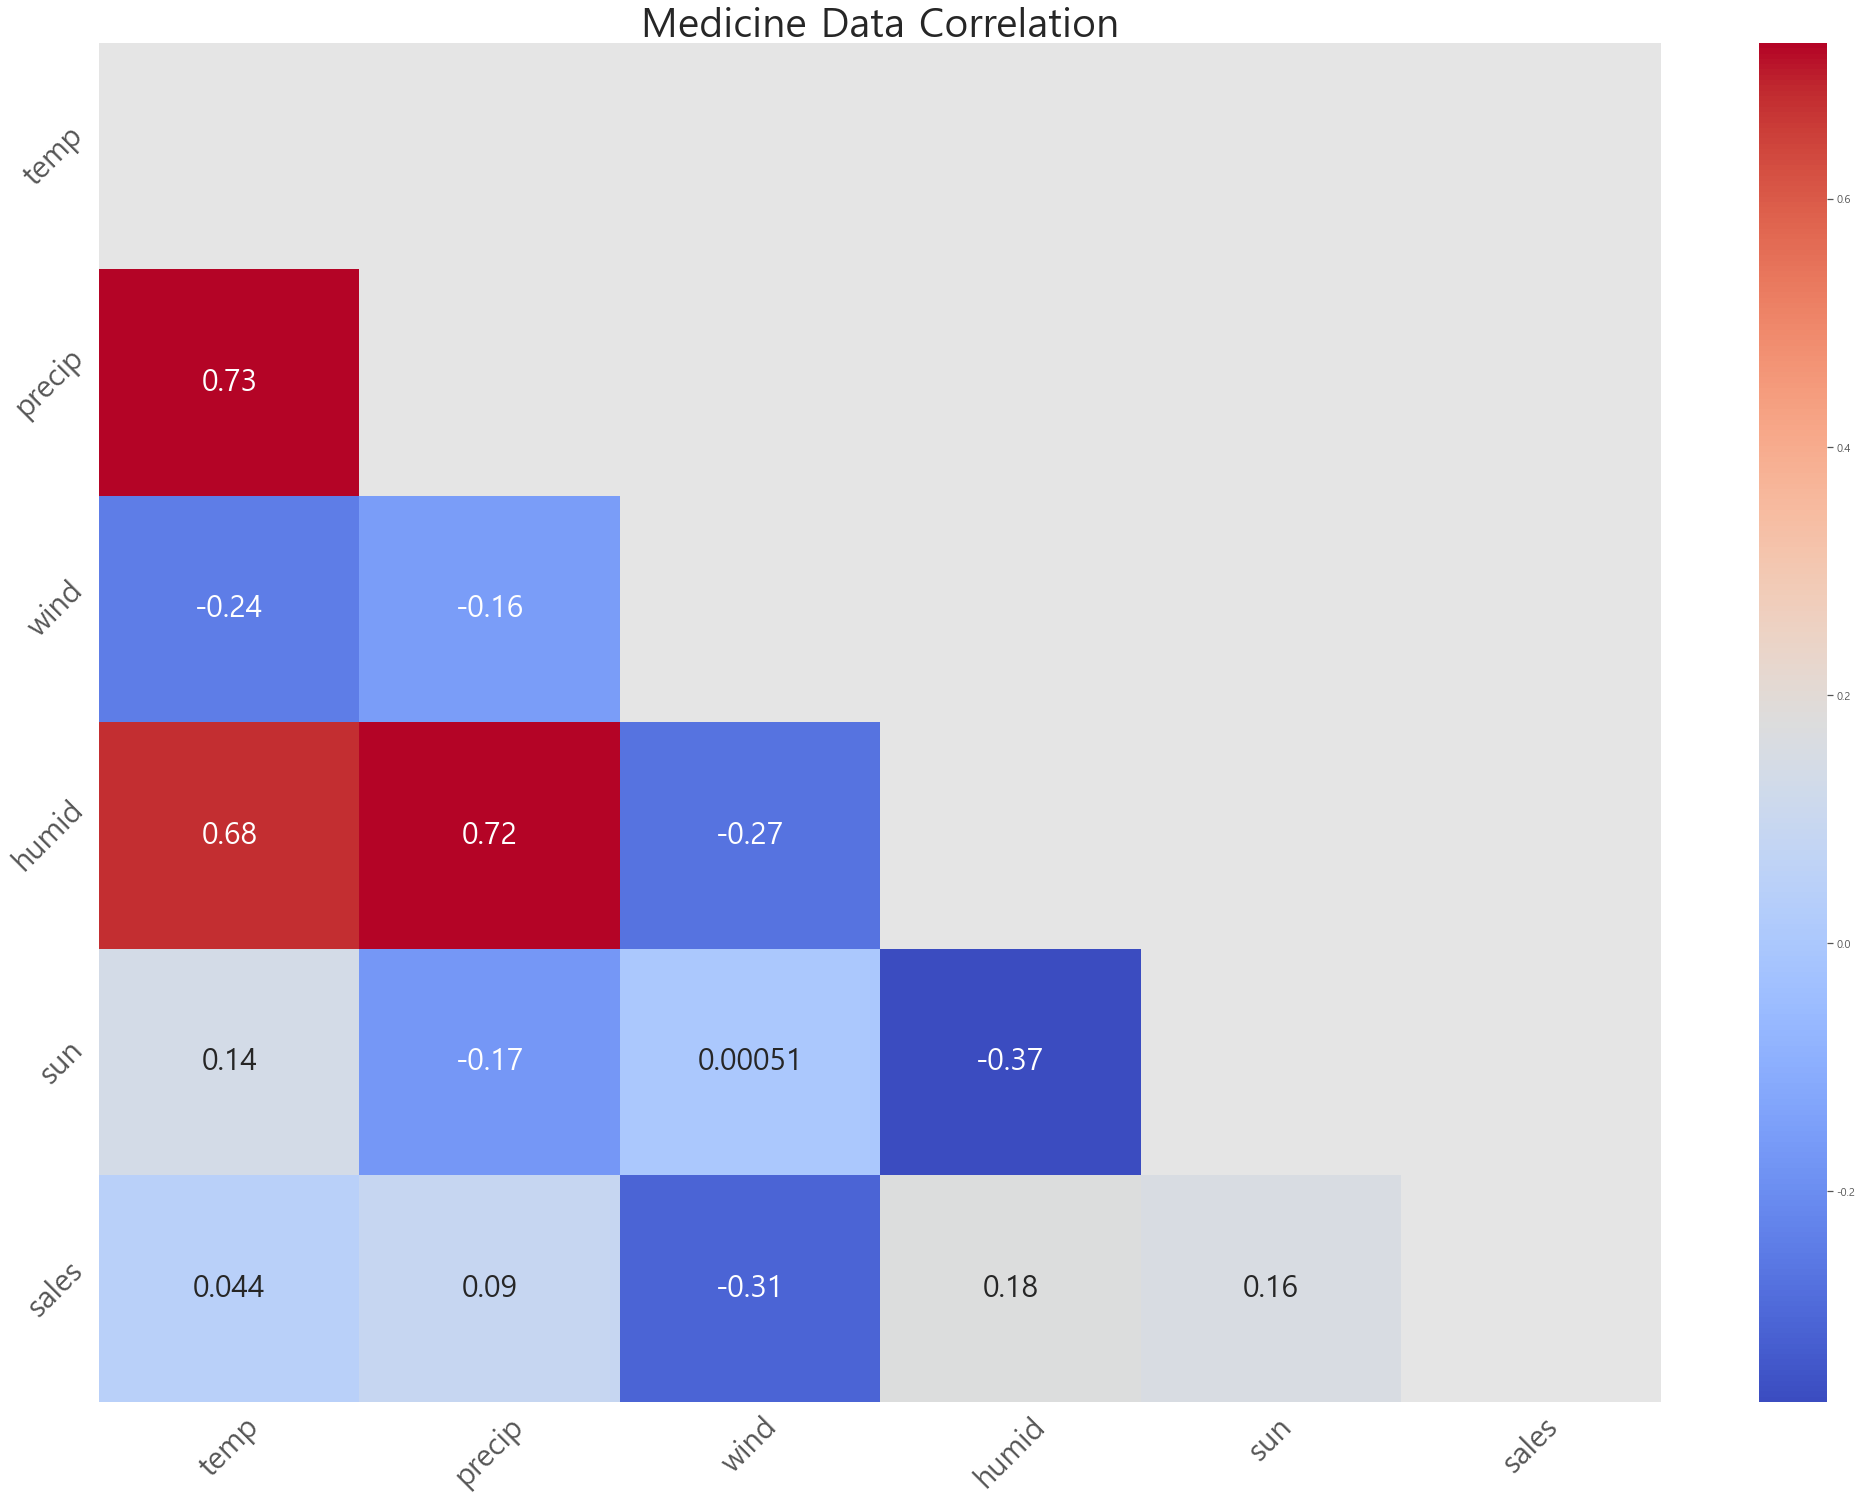

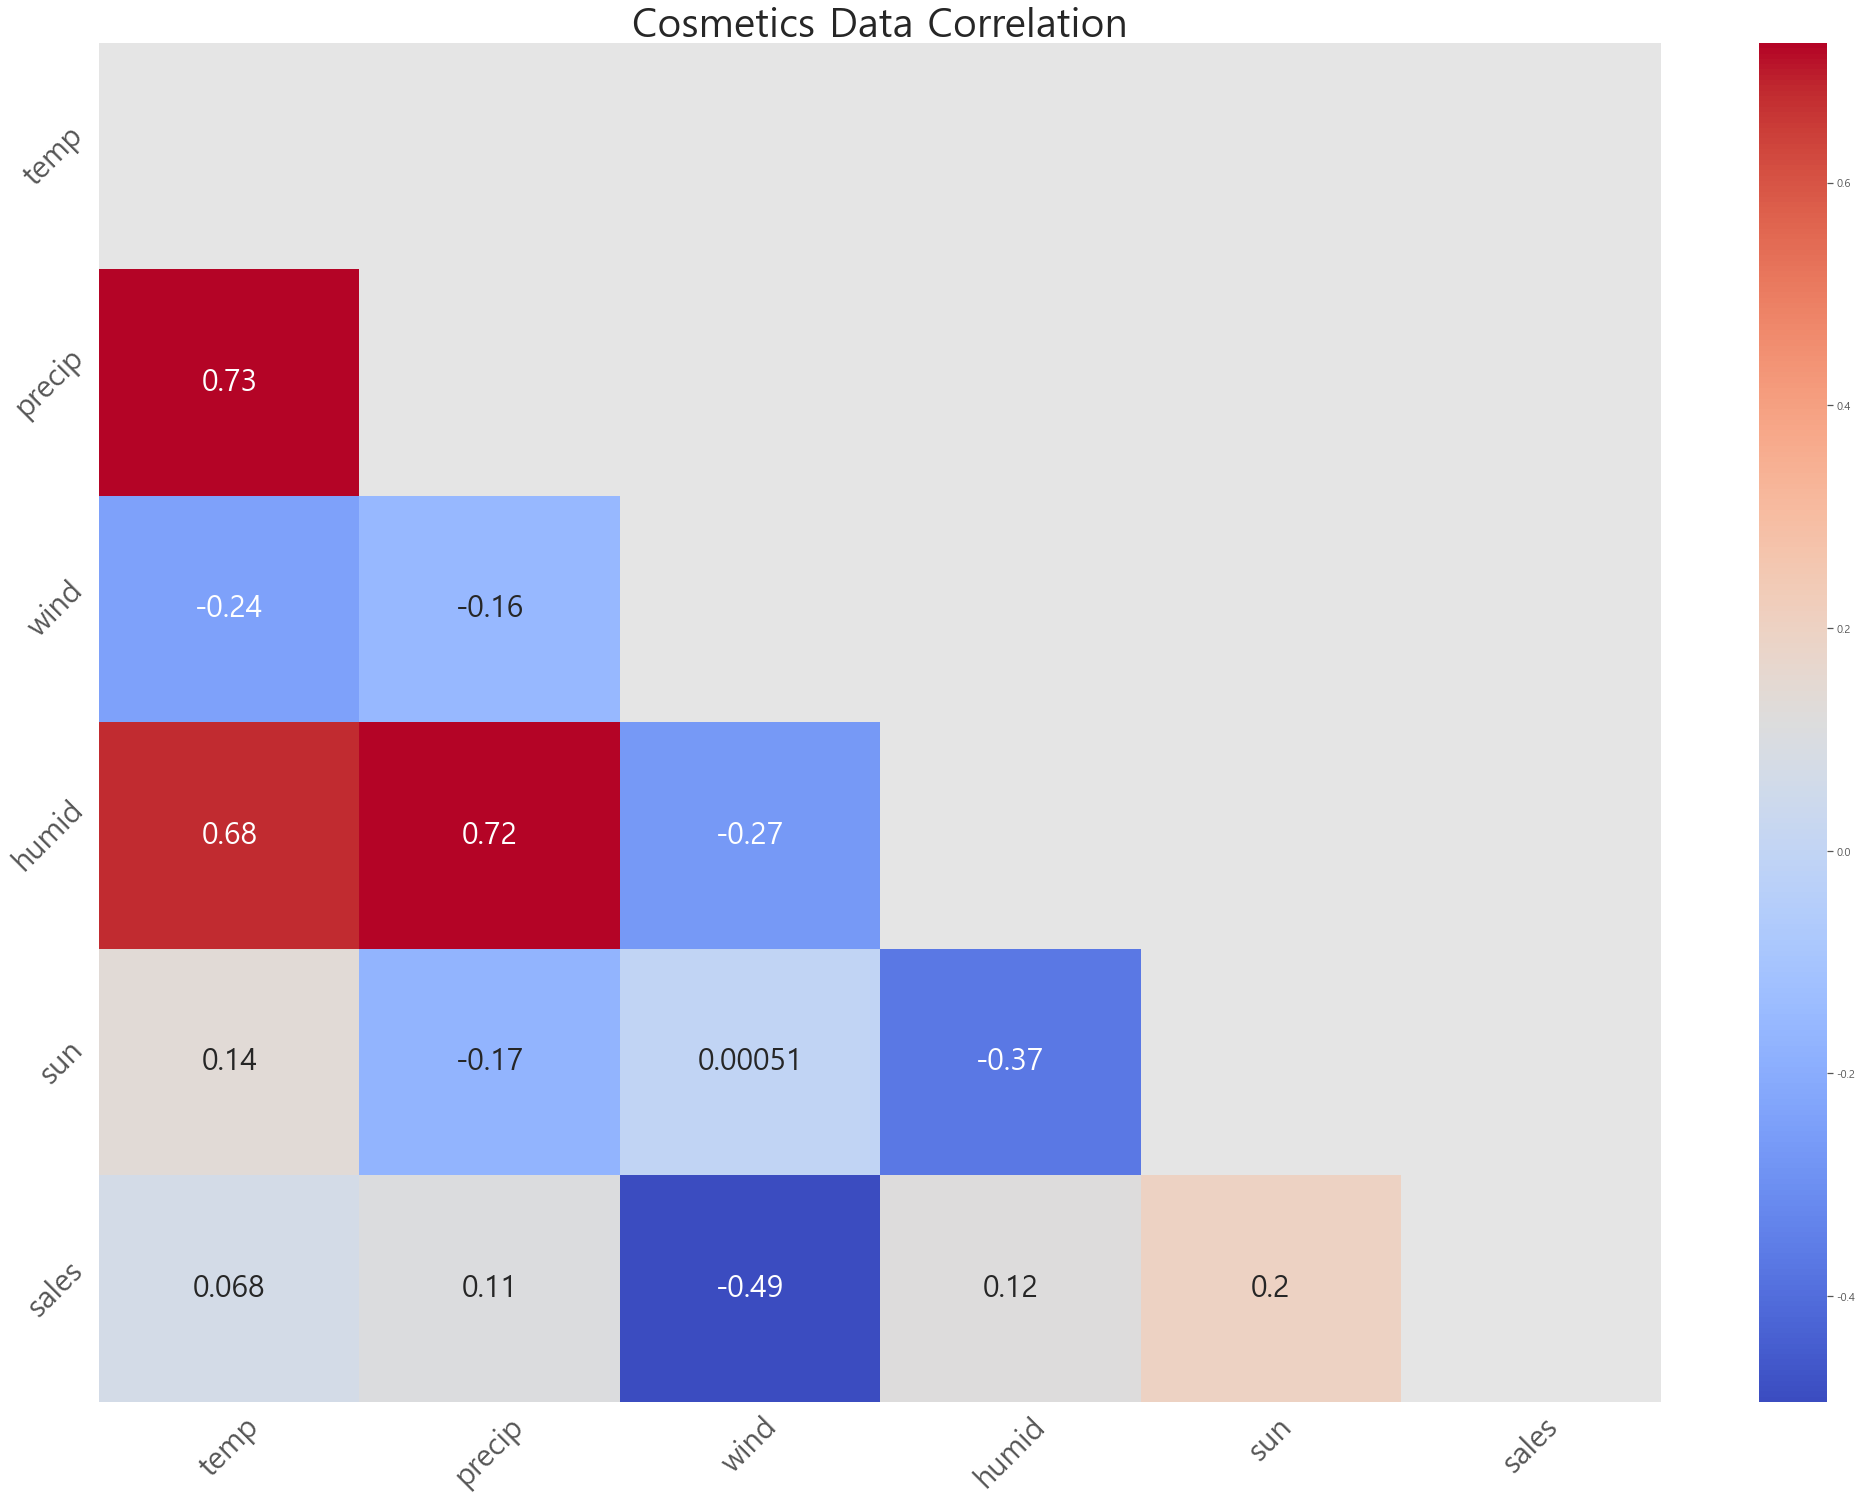

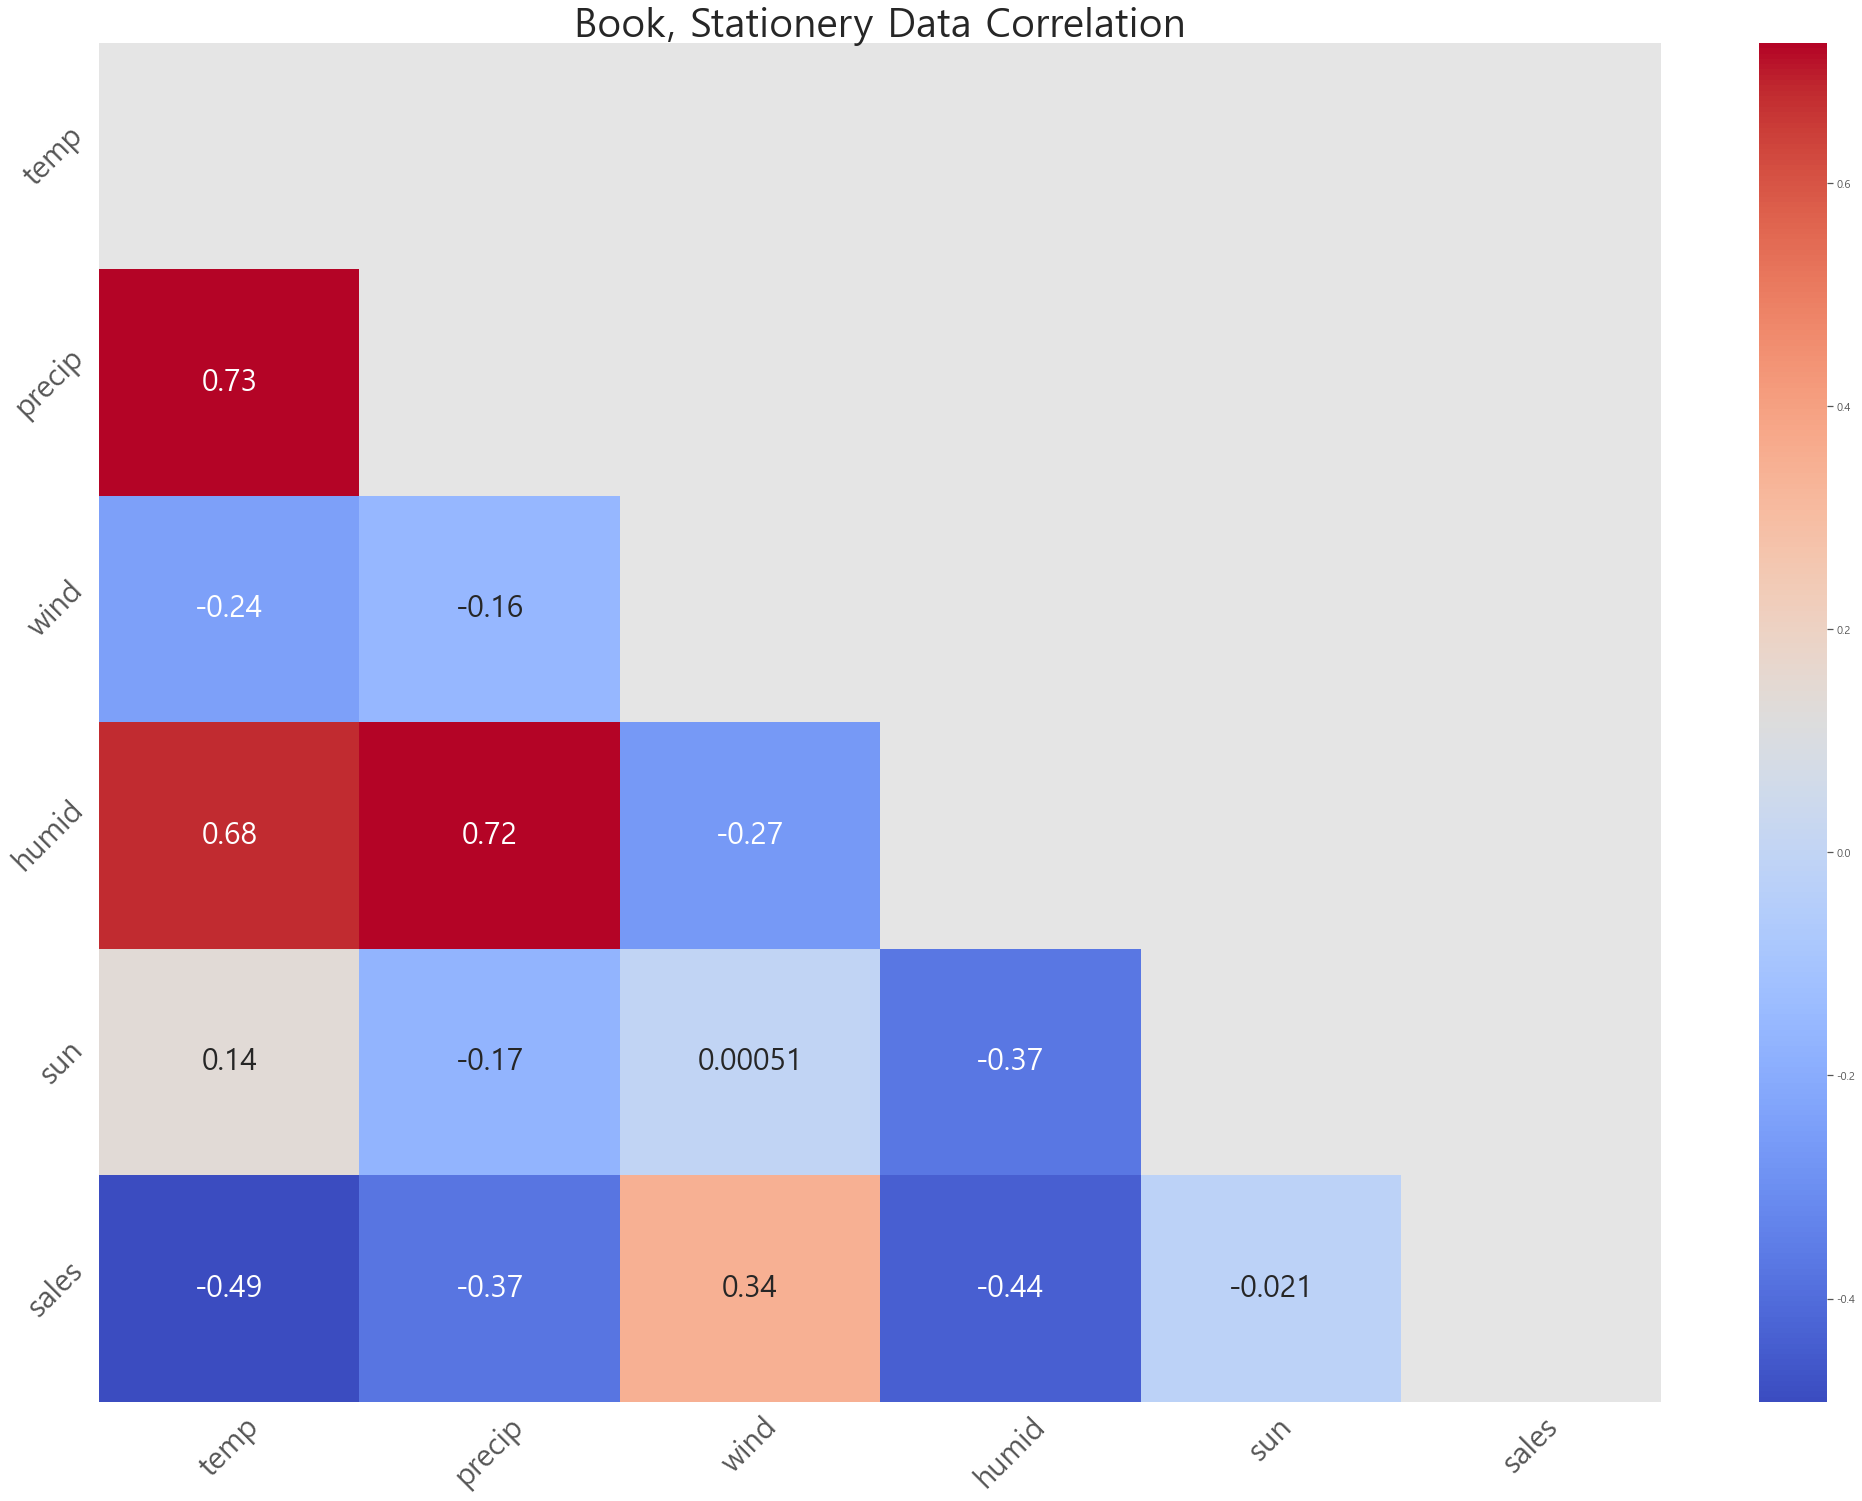

In [11]:
def plot_heatmap(df,title):
    plt.figure(figsize=(35,25))
    heat_table = df.corr(method="pearson")
    mask = np.zeros_like(heat_table)
    mask[np.triu_indices_from(mask)] = True
    heatmap_ax = sns.heatmap(heat_table, annot=True, annot_kws={"fontsize":30}, mask = mask, cmap='coolwarm')
    heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=30, rotation=45)
    heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=30, rotation=45)
    plt.title(f'{title} Data Correlation', fontsize=40)
    plt.show()

# 각 데이터에 따른 히트맵 분석 (마지막 증감여부 제외)
for i,p in enumerate(product_columns):
    plot_heatmap(df_dict[p].iloc[:,:-1], product_list[i])


## 3. Modeling
### (1) ANOVA 분석
- 귀무 가설 : <u>각 날씨 변수별로 높은 판매지수 집단과 낮은 판매지수 집단이 차이가 없다</u>

In [12]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 판매지수 증감여부에 따른 날씨 데이터 ANOVA
for i,p in enumerate(product_columns):
    print(f'상품군 :{p}\n')
    tmp_increase = df_dict[p].loc[df_dict[p]['sales_increase']==1][['temp','precip', 'wind', 'humid', 'sun']]
    tmp_decrease = df_dict[p].loc[df_dict[p]['sales_increase']==0][['temp','precip', 'wind', 'humid', 'sun']]
    
    cols = ['temp','precip', 'wind', 'humid', 'sun']
    
    for col in cols:
        print(f'변수 :{col}\n')
        model = ols(f'sales_increase ~ {col}', df_dict[p][['sales_increase']+[col]]).fit()
        display(anova_lm(model))
    print('------------------------------------\n')


상품군 :승용차

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,1.724706,1.724706,7.145712,0.008096
Residual,213.0,51.410178,0.241362,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,0.537793,0.537793,2.177875,0.141484
Residual,213.0,52.597091,0.246935,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.022645,0.022645,0.090816,0.763436
Residual,213.0,53.112238,0.249353,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,0.494814,0.494814,2.00219,0.158532
Residual,213.0,52.640070,0.247136,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.410894,0.410894,1.659974,0.199005
Residual,213.0,52.723989,0.247530,NaN,NaN


------------------------------------

상품군 :가전제품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,3.574028,3.574028,15.686288,0.000113
Residual,159.0,36.227214,0.227844,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,3.831325,3.831325,16.935837,0.000062
Residual,159.0,35.969917,0.226226,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,2.369149,2.369149,10.063415,0.001816
Residual,159.0,37.432093,0.235422,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,8.529641,8.529641,43.368837,6.285015e-10
Residual,159.0,31.271601,0.196677,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.766922,0.766922,3.123932,0.079069
Residual,159.0,39.034320,0.245499,NaN,NaN


------------------------------------

상품군 :가구

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,3.391768,3.391768,14.681595,0.000183
Residual,159.0,36.732456,0.231022,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,1.739258,1.739258,7.204434,0.008043
Residual,159.0,38.384966,0.241415,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,4.533352,4.533352,20.252467,0.000013
Residual,159.0,35.590872,0.223842,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,3.907391,3.907391,17.15432,0.000056
Residual,159.0,36.216833,0.227779,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.151505,0.151505,0.602644,0.438724
Residual,159.0,39.972718,0.251401,NaN,NaN


------------------------------------

상품군 :의복

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,2.977033,2.977033,12.763848,0.000468
Residual,159.0,37.085078,0.233239,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,1.456668,1.456668,5.999416,0.015396
Residual,159.0,38.605444,0.242802,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,1.811331,1.811331,7.529301,0.006768
Residual,159.0,38.250781,0.240571,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,2.431045,2.431045,10.271728,0.001633
Residual,159.0,37.631067,0.236673,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.001529,0.001529,0.006068,0.93801
Residual,159.0,40.060583,0.251953,NaN,NaN


------------------------------------

상품군 :가방

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,1.310432,1.310432,5.395145,0.021967
Residual,114.0,27.689568,0.242891,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,0.732413,0.732413,2.953738,0.088394
Residual,114.0,28.267587,0.247961,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.162165,0.162165,0.641061,0.424992
Residual,114.0,28.837835,0.252963,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,0.622576,0.622576,2.501062,0.11654
Residual,114.0,28.377424,0.248925,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.081883,0.081883,0.322796,0.571049
Residual,114.0,28.918117,0.253668,NaN,NaN


------------------------------------

상품군 :음식료품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,0.368762,0.368762,1.535292,0.217146
Residual,159.0,38.190244,0.240190,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,0.752891,0.752891,3.16641,0.077078
Residual,159.0,37.806115,0.237774,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,4.164797,4.164797,19.253321,0.000021
Residual,159.0,34.394209,0.216316,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,1.808306,1.808306,7.82354,0.005794
Residual,159.0,36.750701,0.231136,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.291974,0.291974,1.213156,0.272373
Residual,159.0,38.267032,0.240673,NaN,NaN


------------------------------------

상품군 :의약품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,0.005484,0.005484,0.022294,0.881497
Residual,159.0,39.112528,0.245991,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,0.017235,0.017235,0.070084,0.791557
Residual,159.0,39.100778,0.245917,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.098008,0.098008,0.399368,0.528324
Residual,159.0,39.020004,0.245409,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,0.000725,0.000725,0.002947,0.956778
Residual,159.0,39.117287,0.246021,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.115225,0.115225,0.469732,0.494109
Residual,159.0,39.002787,0.245301,NaN,NaN


------------------------------------

상품군 :화장품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,0.508448,0.508448,2.085144,0.150706
Residual,159.0,38.771055,0.243843,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,0.491607,0.491607,2.015204,0.157688
Residual,159.0,38.787896,0.243949,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.162209,0.162209,0.659331,0.41801
Residual,159.0,39.117294,0.246021,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,0.318392,0.318392,1.299357,0.256045
Residual,159.0,38.961111,0.245038,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.017886,0.017886,0.072435,0.788172
Residual,159.0,39.261617,0.246928,NaN,NaN


------------------------------------

상품군 :서적, 문구

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,15.093575,15.093575,98.618396,2.204101e-18
Residual,159.0,24.334997,0.153050,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,6.795975,6.795975,33.112906,4.350604e-08
Residual,159.0,32.632596,0.205236,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,1.957908,1.957908,8.308029,0.004493
Residual,159.0,37.470663,0.235665,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,9.158436,9.158436,48.106535,9.609785e-11
Residual,159.0,30.270135,0.190378,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.125107,0.125107,0.506114,0.477868
Residual,159.0,39.303464,0.247192,NaN,NaN


------------------------------------



### (2) 로지스틱 회귀 모델 학습

월 평균 날씨 정보를 입력받아, 제품 군 별 판매지수가 높을 지/낮을 지에 대한 분류 모델 학습

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error

results_by_seed = []

# 각 제품별 최고 성능 모델 값을 저장하기 위한 변수 설정
best_logistic_model_dict = {p:None for p in product_columns}
best_logistic_data_dict = {p:None for p in product_columns}
best_logistic_result_dict = {p:None for p in product_columns}

# 각 seed 별 학습 진행
for s in list(range(0, 50, 1)):
    results_accuracy = []
    results_precision = []
    results_recall = []
    # 각 제품 별 모델 학습
    for i,p in enumerate(product_columns):
        X = df_dict[p].iloc[:,1:-2]
        Ys = df_dict[p].iloc[:,-2:]

        # Normalization
        X = (X - X.mean()) / X.std()
        Ys.iloc[:,0] = (Ys.iloc[:,0] - Ys.iloc[:,0].mean()) / Ys.iloc[:,0].std() 

        # Train Test 데이터 나누기
        X_train, X_test, y_train, y_test = train_test_split(X, Ys,
                                         train_size = 0.8,
                                         random_state = s)

        # Logistic Regression 모델 학습
        logistic_model = LogisticRegression()
        logistic_model.fit(X_train, y_train.iloc[:,1])

        # test
        y_pred_logistic = logistic_model.predict(X_test)
        acc = accuracy_score(y_test.iloc[:,1], y_pred_logistic)
        precision = precision_score(y_test.iloc[:,1], y_pred_logistic)
        recall = recall_score(y_test.iloc[:,1], y_pred_logistic)

        # test 결과 저장
        results_accuracy.append(acc)
        results_precision.append(precision)
        results_recall.append(recall)

        # 최고 성능 모델 저장
        if best_logistic_model_dict[p] is None:
            best_logistic_model_dict[p] = logistic_model
            best_logistic_result_dict[p] = {"acc":acc,
                                            "precision":precision,
                                            "recall":recall}
            best_logistic_data_dict[p] = {"x_test":X_test,
                                          "y_pred":y_pred_logistic,
                                          "y_test":y_test.iloc[:,1]}
        else:
            if best_logistic_result_dict[p]['acc'] < acc:
                best_logistic_model_dict[p] = logistic_model
                best_logistic_result_dict[p] = {"acc":acc,
                                                "precision":precision,
                                                "recall":recall}
                best_logistic_data_dict[p] = {"x_test":X_test,
                                              "y_pred":y_pred_logistic,
                                              "y_test":y_test.iloc[:,1]}
    # 결과 저장
    results_df = pd.DataFrame({'acc':results_accuracy,
                               'precision':results_precision,
                               'recall':results_recall}, index=product_list)
    results_by_seed.append(results_df)

로지스틱 회귀 모델 학습 결과

- 평균 결과

In [14]:
print("Seed 값 변경에 따른 평균 성능")
display(sum(results_by_seed)/ len(results_by_seed))

Seed 값 변경에 따른 평균 성능


,acc,precision,recall
Car,0.593953,0.624721,0.717918
Electronic,0.683636,0.667075,0.582004
Furniture,0.640606,0.667671,0.699280
Cloth,0.650909,0.660073,0.757521
Bag,0.529167,0.516332,0.579036
Food,0.647273,0.607553,0.402910
Medicine,0.520606,0.553264,0.875966
Cosmetics,0.531515,0.566373,0.833718
"Book, Stationery",0.800000,0.771647,0.781281


- 최고 성능 모델에 대한 결과

In [15]:
acc = [result['acc'] for result in best_logistic_result_dict.values()]
precision = [result['precision'] for result in best_logistic_result_dict.values()]
recall = [result['recall'] for result in best_logistic_result_dict.values()]

best_result_df=pd.DataFrame({'acc': acc,
                             'precision': precision,
                             'recall': recall}, index=product_list)
display(best_result_df)

,acc,precision,recall
Car,0.767442,0.781250,0.892857
Electronic,0.848485,0.941176,0.800000
Furniture,0.878788,0.857143,0.947368
Cloth,0.848485,0.789474,0.937500
Bag,0.708333,0.692308,0.750000
Food,0.787879,0.875000,0.538462
Medicine,0.666667,0.724138,0.875000
Cosmetics,0.666667,0.730769,0.826087
"Book, Stationery",0.939394,0.888889,0.888889


각 제품별 분석에 대한 ROC_AUC curve 및 Confusion Matrix

ROC AUC curve


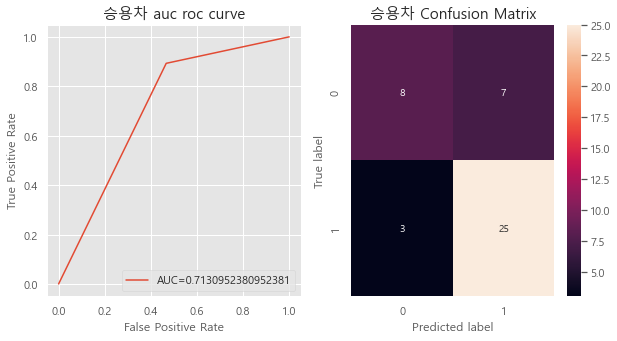

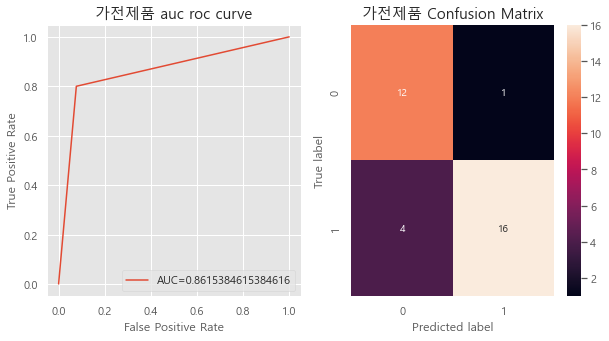

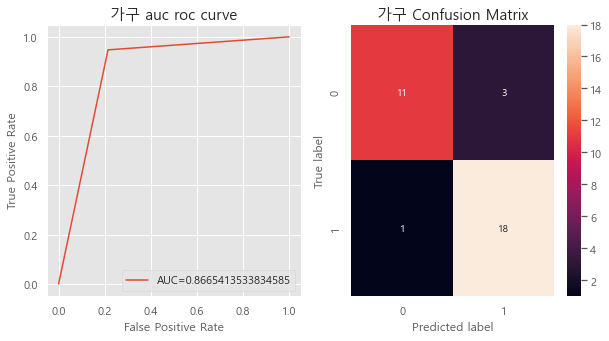

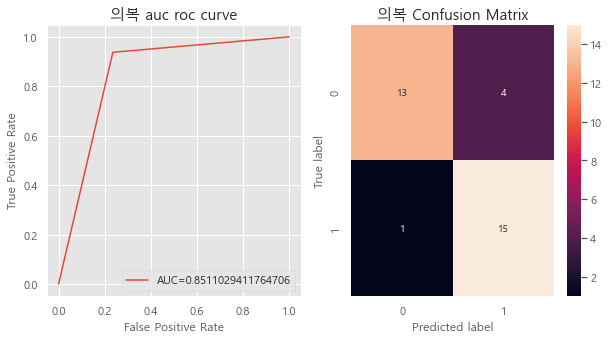

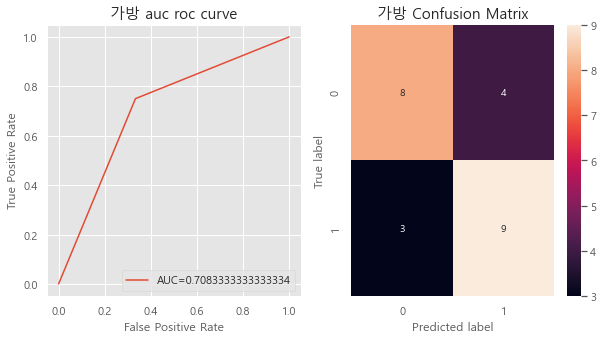

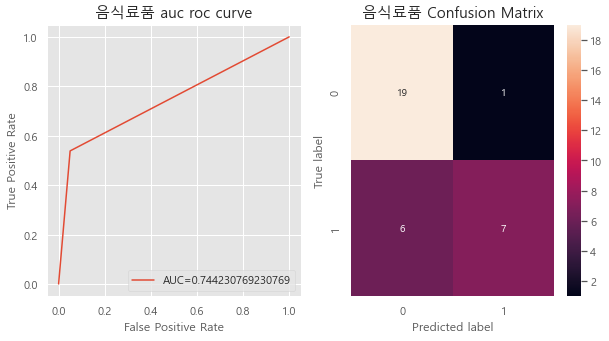

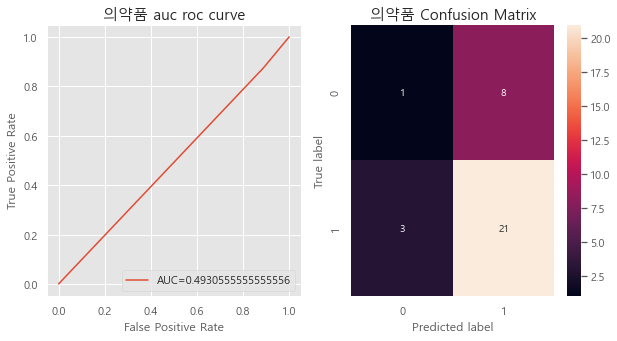

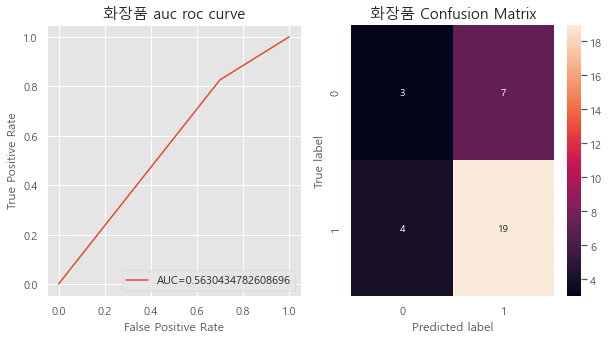

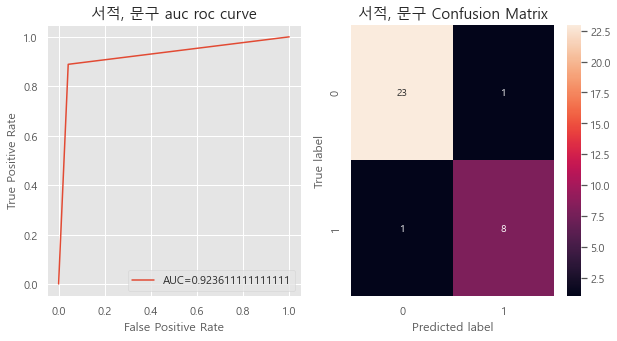

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
def plot_roc_auc_with_confusion_matrix(p):
    # 최고 성능에 대한 데이터
    x_test, y_pred, y_test = list(best_logistic_data_dict[p].values())
    # roc auc 값 계산
    roc_auc = roc_auc_score(y_test, y_pred)
    # false positive rate, true positive rate 계산
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    # confusion matrix 결과 계산
    cm = confusion_matrix(y_test, y_pred)

    # roc auc curve 그리기
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'AUC={roc_auc}')
    plt.title(f"{p} auc roc curve", fontsize=15)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)

    # confusion matrix 그리기
    ax = plt.subplot(1,2,2)
    sns.heatmap(data=cm, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f"{p} Confusion Matrix", fontsize=15)

    plt.show()

print('ROC AUC curve')
for p in best_logistic_model_dict.keys():
    plot_roc_auc_with_confusion_matrix(p)

학습된 모델의 선형 계수(coefficient)

In [17]:
print('학습된 모델의 Coefficient \n')
for p, model in best_logistic_model_dict.items():
    print(f"{p} model Coefficient : {model.coef_}")
    print(f"{p} model Intercept : {model.intercept_}")
    print()

학습된 모델의 Coefficient 

승용차 model Coefficient : [[ 0.26872192 -0.07085609 -0.05828467 -0.0317809   0.09984704]]
승용차 model Intercept : [0.13106869]

가전제품 model Coefficient : [[-0.2800619   0.08362346 -0.21362556  0.94654139  0.08011222]]
가전제품 model Intercept : [-0.32990812]

가구 model Coefficient : [[-0.46112641  0.25777401  0.47055635 -0.2479089   0.13252912]]
가구 model Intercept : [0.09154205]

의복 model Coefficient : [[-0.21916907 -0.00501986  0.23503441 -0.18135842 -0.12463799]]
의복 model Intercept : [0.18256572]

가방 model Coefficient : [[-0.349668   -0.00861299  0.03301025  0.05867965 -0.02594556]]
가방 model Intercept : [-0.00890596]

음식료품 model Coefficient : [[-0.31829731  0.14929959 -0.61474129  0.33606362  0.05284221]]
음식료품 model Intercept : [-0.46581694]

의약품 model Coefficient : [[-0.25672949 -0.06034081  0.11676311  0.34301175  0.18620932]]
의약품 model Intercept : [0.20019482]

화장품 model Coefficient : [[-0.09696364  0.08409467 -0.09216784 -0.37432798 -0.23844322]]
화장품 model Intercept :

# 4. 딥러닝을 이용한 주식 가격 예측
23일전 ~ 현재 주식 가격을 통해 다음날의 주식 가격을 예측하는 모델 학습

- Data : Weather data + Stock data (daily)
- Model : GRU model

LG Electronics Inc Stock prediction training start


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


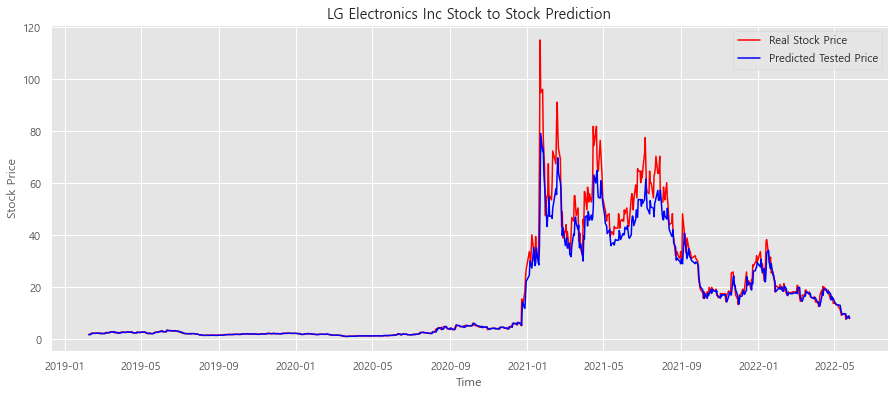

Test Score: 26.471% MAPE

LG Electronics Inc Stock prediction with weather data training start


100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


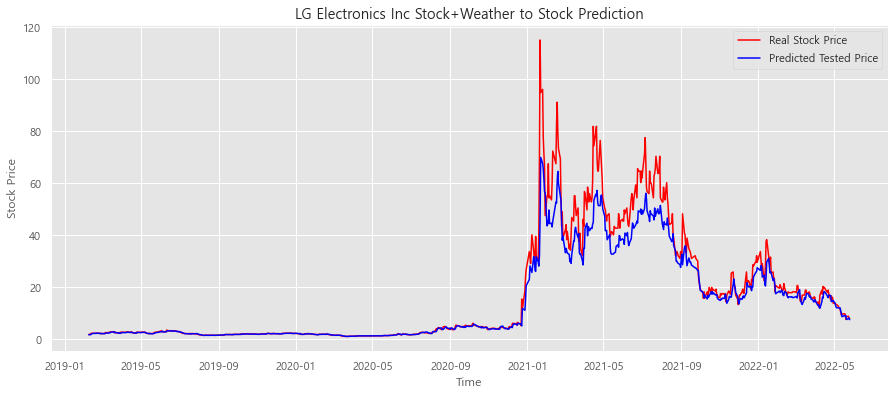

Test Score: 29.872% MAPE



In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_percentage_error
import math
from typing import List, Callable
from tqdm import tqdm
torch.manual_seed(5)

def load_data(company_name):
    # weather datas
    data_root = './data/daily'
    temp_df = pd.read_csv(f'{data_root}/Temperatures.csv', encoding='cp949')
    precip_df = pd.read_csv(f'{data_root}/Precipitation.csv', encoding='cp949').fillna(0)
    wind_df = pd.read_csv(f'{data_root}/Wind.csv', encoding='cp949')
    humidity_df = pd.read_csv(f'{data_root}/Humidity.csv', encoding='cp949')
    sunshine_df = pd.read_csv(f'{data_root}/Sunshine.csv', encoding='cp949')
    # merge weather data
    weather_df = temp_df.merge(precip_df).merge(wind_df).merge(humidity_df).merge(sunshine_df)
    weather_columns = ["평균기온", "강수량mm", "평균풍속ms", "평균습도rh","일조합"]
    selected_weather_df = weather_df[['일시']+weather_columns]

    # stock data
    stock_price_df = pd.read_csv(f'./data/stock/{company_name}.csv')
    stock_columns = ['Close']
    selected_stock_df = stock_price_df[['Date'] + stock_columns].dropna()

    # merge stock and weather data
    stock_weather_df = selected_weather_df.rename(columns={"일시":"Date"}).merge(selected_stock_df).dropna()

    # 주식 데이터를 log 스케일로 변경
    stock_weather_df['Close'] = np.log(1+stock_weather_df['Close'])

    # 2019년 기준으로 Train, Test 데이터 분리

    train_date = stock_weather_df[stock_weather_df['Date'] < '2019-01-01']['Date'].reset_index(drop=True)
    test_date = stock_weather_df[stock_weather_df['Date'] >= '2019-01-01']['Date'].reset_index(drop=True)

    train_df = stock_weather_df[stock_weather_df['Date'] < '2019-01-01'].drop(columns='Date')
    test_df = stock_weather_df[stock_weather_df['Date'] >= '2019-01-01'].drop(columns='Date')

    # Normalize
    train_mean, train_std = train_df.mean(), train_df.std()
    train_df = (train_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    return train_df, test_df, train_date, test_date

# 데이터
class StockDataset(Dataset):
    def __init__(self, df, t_dim, label:List = None,):
        super(StockDataset, self).__init__()
        self.df = df.reset_index(drop=True)
        self.t_dim = t_dim
        if label is None:
            label = df.columns
        self.label = label
        self.total_length = len(df) - (t_dim + 1)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        x = self.df.loc[idx: idx+self.t_dim-1].values
        y = self.df.loc[idx+self.t_dim][self.label].values
        return x, y

# 모델 정의
class StockModel(nn.Module):
    def __init__(self, input_dim, h_c=256, num_layers=2):
        super(StockModel, self).__init__()
        self.input_dim = input_dim
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=h_c, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(in_features=h_c, out_features=1)

    def forward(self, x):
        output, hn = self.rnn(x)
        return self.fc(output[:, -1, :])

# 학습과정 정의
def train(model, train_loader, criterion, optimizer,
          epochs=10, device=torch.device('cpu'), valid_loader=None,
          verbose=True):
    model = model.to(device)
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        # train
        for step, (x, y) in enumerate(train_loader):
            x, y = x.float().to(device), y.float().to(device)
            optimizer.zero_grad()

            pred = model(x)
            loss =criterion(pred, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if verbose:
                if (step+1) % 100 == 0:
                    print(f"{epoch+1} epoch : {step+1 :5d}step - loss={running_loss/(step+1)}")
        if verbose:
            print(f"{epoch+1} epoch : {step+1 :5d}step - loss={running_loss/(step+1)}")

        # valid
        if valid_loader is not None:
            valid_loss = 0
            for step, (x, y) in enumerate(valid_loader):
                x, y = x.float().to(device), y.float().to(device)
                pred = model(x)
                pred = torch.exp(pred) + 1
                y = torch.exp(y) + 1
                valid_loss += mean_absolute_percentage_error(y.detach().cpu().numpy().squeeze(),
                                                             pred.detach().cpu().numpy().squeeze())
            if verbose:
                print(f"valid_loss={valid_loss}")

    return model

# 모델에서 결과 데이터 추출을 위한 함수
def get_result(model, ds, device=torch.device('cpu')):
    model_y_pred = []
    model_y_true = []
    model.eval()
    for x, y in DataLoader(ds, batch_size=1):
        y_pred = model(x.float().to(device))
        model_y_pred.append(y_pred.detach().cpu().numpy())
        model_y_true.append(y.detach().cpu().numpy())
    y_preds = np.exp(np.concatenate(model_y_pred)).squeeze() +1
    y_trues = np.exp(np.concatenate(model_y_true)).squeeze() + 1
    return y_preds, y_trues

# 학습 결과
def plot_results(test_results, title_name:str):
    import datetime as dt
    def get_date_axis(y_list, date_df):
        return [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in date_df[np.arange(t_dim,len(y_list)+t_dim)]]

    test_y_preds, test_y_trues = test_results

    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    # plot true data
    axes.plot(get_date_axis(test_y_trues, test_date),
              test_y_trues,
              color = 'red', label = 'Real Stock Price')
    # plot pred data
    axes.plot(get_date_axis(test_y_preds, test_date), test_y_preds, color = 'blue', label = 'Predicted Tested Price')

    plt.title(f'{title_name}')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    testScore = math.sqrt(mean_absolute_percentage_error(test_y_trues, test_y_preds))
    print(f'Test Score: {testScore*100:.3f}% MAPE')
    print()


companies = ['LG Electronics Inc']
batch_size=32
t_dim =  24
epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for i, company in enumerate(companies):
    train_data, test_data, train_date, test_date = load_data(company)

    # stock to stock 데이터
    train_ds = StockDataset(train_data[['Close']], t_dim=t_dim, label=['Close'])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_ds = StockDataset(test_data[['Close']], t_dim=t_dim, label=['Close'])
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
    # stock to stock(s2s) 모델 준비&학습
    model = StockModel(1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print(f'{company} Stock prediction training start')
    model = train(model, train_loader, criterion, optimizer, epochs,
                  valid_loader=test_loader, device=device, verbose=False)
    # 학습된 결과 추출
    s2s_train_results = get_result(model, train_ds, device=device)
    s2s_test_results = get_result(model, test_ds, device=device)
    # 그래프
    plot_results(s2s_test_results, title_name=f'{company} Stock to Stock Prediction')

    # stock+weather to stock 데이터
    train_ds = StockDataset(train_data, t_dim=t_dim, label=['Close'])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_ds = StockDataset(test_data, t_dim=t_dim, label=['Close'])
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

    # stock+weather to stock(sw2s) 모델 준비&학습
    print(f'{company} Stock prediction with weather data training start')
    model = StockModel(len(train_data.columns))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model = train(model, train_loader, criterion, optimizer, epochs,
                  valid_loader=test_loader, device=device, verbose=False)

    # 학습된 결과 추출
    sw2s_train_results = get_result(model, train_ds, device=device)
    sw2s_test_results = get_result(model, test_ds, device=device)
    # 학습된 결과 그래프
    plot_results(sw2s_test_results, title_name=f'{company} Stock+Weather to Stock Prediction')